# CE807 Assignment - Logistic Regression Based Text Classification

This notebook implements two text classification models using Logistic Regression:
- **Model 1**: Traditional Tokenization combined with TF-IDF Vectorization
- **Model 2**: BERT Tokenization using CLS Embeddings

The implementation is structured to follow:
- Python code style guidelines as per PEP8: https://peps.python.org/pep-0008/
- Best practices in code documentation and readability
- Evaluation and comparison of model performance on train, validation, and test sets
- Automated saving of outputs and models in the required directory structure

## 1.1 Student and Dataset Information
- Student ID: 2411729
- Dataset Folder: ./data/47/

## 1.2 Notebook Structure

| Step | Description |
|------|-------------|
| Setup | Install packages and configure paths |
| Load Data | Read training, validation, and test data |
| Preprocess | Perform traditional tokenization and cleaning |
| Model 1 | TF-IDF features with Logistic Regression |
| Model 2 | BERT CLS embeddings with Logistic Regression |
| Evaluation | Print performance metrics across all splits |
| SoTA Comparison | Provide context by comparing with existing works |
| Output Saving | Save test predictions to test.csv |

## 1.3 Setup: Install Required Packages

This cell ensures that all necessary Python libraries are installed before proceeding.

The following libraries are used in this notebook:
- nltk: For natural language processing tasks including tokenization and stemming
- transformers: HuggingFace library for BERT tokenizer and embeddings
- scikit-learn: For vectorization, modeling, and evaluation
- gdown: For downloading any shared models from Google Drive if needed

Packages will be installed using pip only if they are not already available in the environment.

In [ ]:
import subprocess
import sys

def install_if_missing(package_name):
    """
    Install a Python package using pip if it is not already installed.

    Args:
        package_name (str): The name of the package to check and install.

    Returns:
        None
    """
    try:
        __import__(package_name)
        print(f"[INFO] Package '{package_name}' is already installed.")
    except ImportError:
        print(f"[INFO] Installing '{package_name}'...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
        print(f"[INFO] Package '{package_name}' installed successfully.")

# List of required libraries
required_packages = ["nltk", "transformers", "scikit-learn", "gdown", "wordcloud"]

# Install each package if missing
for pkg in required_packages:
    install_if_missing(pkg)

print("\nAll required packages are available and ready.")

[INFO] Package 'nltk' is already installed.
[INFO] Package 'transformers' is already installed.
[INFO] Installing 'scikit-learn'...
[INFO] Package 'scikit-learn' installed successfully.
[INFO] Package 'gdown' is already installed.
[INFO] Package 'wordcloud' is already installed.

All required packages are available and ready.


## 1.4 Environment Setup: Import Libraries and Define Paths

This section imports all necessary libraries required throughout the notebook.

Key configuration actions performed:
- Import standard and third-party libraries
- Set a fixed random seed for reproducibility
- Define paths for:
  - Dataset directory based on dataset number
  - Model saving directory based on student ID

These configurations ensure consistency and allow for automatic model retrieval and storage.

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import torch
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Set seed for reproducibility
STUDENT_ID = 2411729
DATASET_NUMBER = 47
SEED = STUDENT_ID

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Define data and model paths
DATA_PATH = f'./data/{DATASET_NUMBER}/'
MODEL_PATH = f'./model/{STUDENT_ID}/'

# Ensure model directory exists
os.makedirs(MODEL_PATH, exist_ok=True)

# Create figures directory
FIG_PATH = os.path.join(MODEL_PATH, 'figures')
os.makedirs(FIG_PATH, exist_ok=True)

print(f"Environment configured with:")
print(f"- Student ID: {STUDENT_ID}")
print(f"- Dataset Number: {DATASET_NUMBER}")
print(f"- Data Path: {DATA_PATH}")
print(f"- Model Path: {MODEL_PATH}")
print(f"- Figures Path: {FIG_PATH}")

Environment configured with:
- Student ID: 2411729
- Dataset Number: 47
- Data Path: ./data/47/
- Model Path: ./model/2411729/
- Figures Path: ./model/2411729/figures


## 1.5 Data Loading: Read Training, Validation, and Test Sets from Google Drive

The dataset files are stored in a structured folder inside Google Drive:
- `./gdrive/MyDrive/CE807-25-SU/Assignment/data/47/`

This section mounts Google Drive, defines the dataset paths, and loads:
- train.csv
- valid.csv
- test.csv

We then verify the structure and preview the contents.

In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/gdrive', force_remount=True)

# Path configuration
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = './CE807-25-SU/Assignment/'
GOOGLE_DRIVE_PATH = os.path.join('gdrive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)

# Define dataset number and student ID again
DATASET_NUMBER = 47
STUDENT_ID = 2411729

# Construct full data path
DATA_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'data', str(DATASET_NUMBER))
MODEL_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'model', str(STUDENT_ID))
os.makedirs(MODEL_PATH, exist_ok=True)

# Update figures path
FIG_PATH = os.path.join(MODEL_PATH, 'figures')
os.makedirs(FIG_PATH, exist_ok=True)

# File paths
train_file = os.path.join(DATA_PATH, 'train.csv')
val_file = os.path.join(DATA_PATH, 'valid.csv')
test_file = os.path.join(DATA_PATH, 'test.csv')

# Confirm file paths
print(f"Train file: {train_file}")
print(f"Validation file: {val_file}")
print(f"Test file: {test_file}")

# Load datasets
train_df = pd.read_csv(train_file)
valid_df = pd.read_csv(val_file)
test_df = pd.read_csv(test_file)

# Confirm loading
print("\nDatasets loaded successfully.")
print(f"Train shape: {train_df.shape}")
print(f"Validation shape: {valid_df.shape}")
print(f"Test shape: {test_df.shape}")

Mounted at /content/gdrive
Train file: gdrive/MyDrive/./CE807-25-SU/Assignment/data/47/train.csv
Validation file: gdrive/MyDrive/./CE807-25-SU/Assignment/data/47/valid.csv
Test file: gdrive/MyDrive/./CE807-25-SU/Assignment/data/47/test.csv

Datasets loaded successfully.
Train shape: (4914, 4)
Validation shape: (700, 4)
Test shape: (1386, 5)


## 1.5.1 Dataset Visualization and Statistics

This section provides visual insights into the dataset distribution and characteristics.

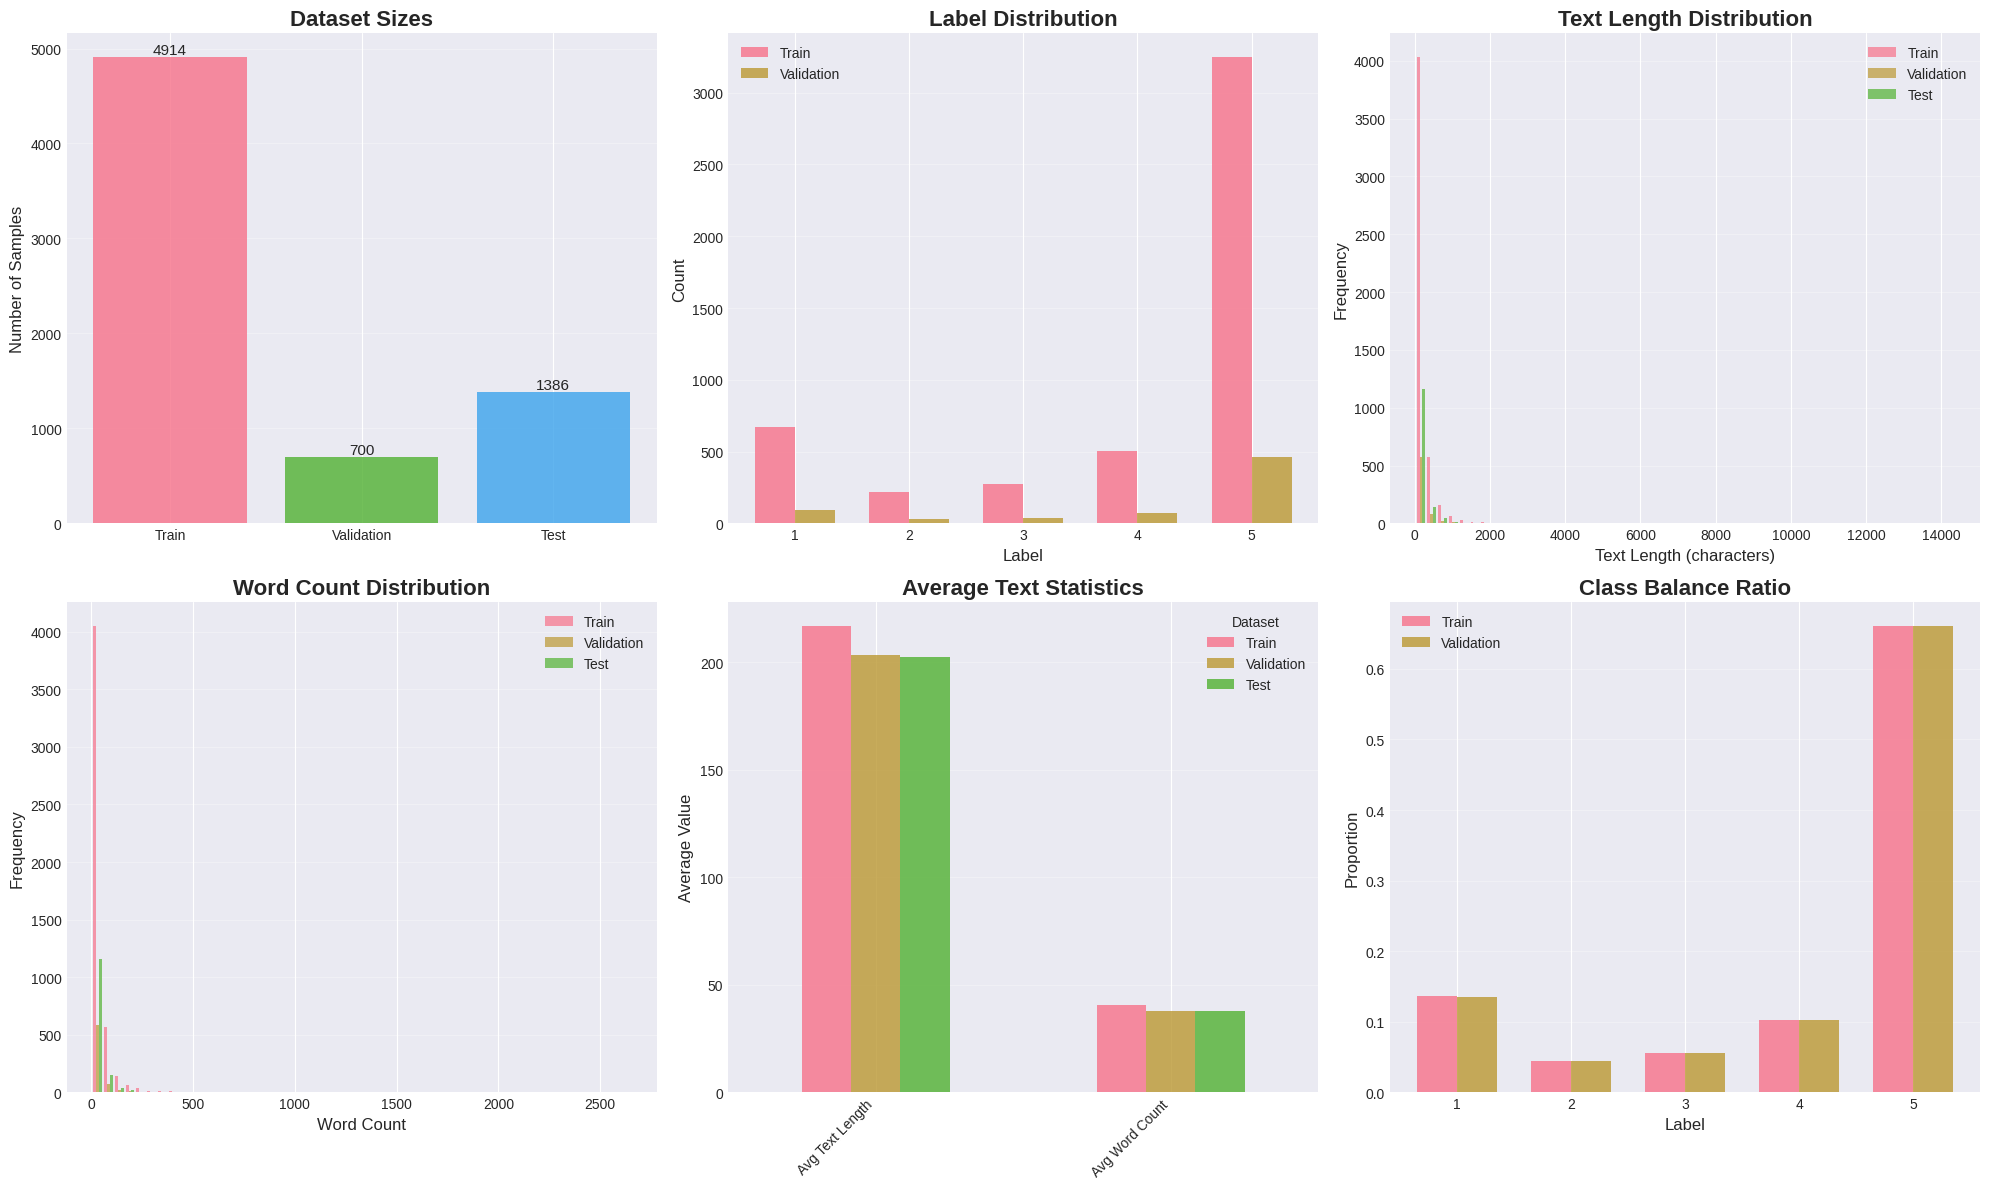


=== Dataset Summary Statistics ===

Average text length:
Train: 216.96 characters
Validation: 203.24 characters
Test: 202.55 characters

Average word count:
Train: 40.40 words
Validation: 37.82 words
Test: 37.65 words


In [ ]:
# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# 1. Create a comprehensive dataset statistics visualization
fig = plt.figure(figsize=(20, 12))

# 1.1 Dataset sizes
ax1 = plt.subplot(2, 3, 1)
dataset_sizes = [len(train_df), len(valid_df), len(test_df)]
dataset_names = ['Train', 'Validation', 'Test']
colors = sns.color_palette("husl", n_colors=3)
bars = ax1.bar(dataset_names, dataset_sizes, color=colors, alpha=0.8)
ax1.set_title('Dataset Sizes', fontsize=16, fontweight='bold')
ax1.set_ylabel('Number of Samples', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontsize=11)

# 1.2 Label distribution (for train and valid only)
ax2 = plt.subplot(2, 3, 2)
if 'rating' in train_df.columns:
    train_df['label'] = train_df['rating']
if 'rating' in valid_df.columns:
    valid_df['label'] = valid_df['rating']

train_labels = train_df['label'].value_counts().sort_index()
valid_labels = valid_df['label'].value_counts().sort_index()

x = np.arange(len(train_labels))
width = 0.35

bars1 = ax2.bar(x - width/2, train_labels.values, width, label='Train', alpha=0.8)
bars2 = ax2.bar(x + width/2, valid_labels.values, width, label='Validation', alpha=0.8)

ax2.set_xlabel('Label', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('Label Distribution', fontsize=16, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(train_labels.index)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 1.3 Text length distribution
ax3 = plt.subplot(2, 3, 3)
train_df['text_length'] = train_df['text'].str.len()
valid_df['text_length'] = valid_df['text'].str.len()
test_df['text_length'] = test_df['text'].str.len()

ax3.hist([train_df['text_length'], valid_df['text_length'], test_df['text_length']],
         bins=50, alpha=0.7, label=['Train', 'Validation', 'Test'])
ax3.set_xlabel('Text Length (characters)', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('Text Length Distribution', fontsize=16, fontweight='bold')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 1.4 Word count distribution
ax4 = plt.subplot(2, 3, 4)
train_df['word_count'] = train_df['text'].str.split().str.len()
valid_df['word_count'] = valid_df['text'].str.split().str.len()
test_df['word_count'] = test_df['text'].str.split().str.len()

ax4.hist([train_df['word_count'], valid_df['word_count'], test_df['word_count']],
         bins=50, alpha=0.7, label=['Train', 'Validation', 'Test'])
ax4.set_xlabel('Word Count', fontsize=12)
ax4.set_ylabel('Frequency', fontsize=12)
ax4.set_title('Word Count Distribution', fontsize=16, fontweight='bold')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# 1.5 Average text statistics
ax5 = plt.subplot(2, 3, 5)
avg_stats = pd.DataFrame({
    'Train': [train_df['text_length'].mean(), train_df['word_count'].mean()],
    'Validation': [valid_df['text_length'].mean(), valid_df['word_count'].mean()],
    'Test': [test_df['text_length'].mean(), test_df['word_count'].mean()]
}, index=['Avg Text Length', 'Avg Word Count'])

avg_stats.plot(kind='bar', ax=ax5, alpha=0.8)
ax5.set_title('Average Text Statistics', fontsize=16, fontweight='bold')
ax5.set_ylabel('Average Value', fontsize=12)
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=45, ha='right')
ax5.legend(title='Dataset')
ax5.grid(axis='y', alpha=0.3)

# 1.6 Class balance ratio
ax6 = plt.subplot(2, 3, 6)
train_ratio = train_labels / train_labels.sum()
valid_ratio = valid_labels / valid_labels.sum()

x_pos = np.arange(len(train_ratio))
bars1 = ax6.bar(x_pos - width/2, train_ratio.values, width, label='Train', alpha=0.8)
bars2 = ax6.bar(x_pos + width/2, valid_ratio.values, width, label='Validation', alpha=0.8)

ax6.set_xlabel('Label', fontsize=12)
ax6.set_ylabel('Proportion', fontsize=12)
ax6.set_title('Class Balance Ratio', fontsize=16, fontweight='bold')
ax6.set_xticks(x_pos)
ax6.set_xticklabels(train_ratio.index)
ax6.legend()
ax6.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(FIG_PATH, 'dataset_statistics.png'), dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n=== Dataset Summary Statistics ===")
print(f"\nAverage text length:")
print(f"Train: {train_df['text_length'].mean():.2f} characters")
print(f"Validation: {valid_df['text_length'].mean():.2f} characters")
print(f"Test: {test_df['text_length'].mean():.2f} characters")

print(f"\nAverage word count:")
print(f"Train: {train_df['word_count'].mean():.2f} words")
print(f"Validation: {valid_df['word_count'].mean():.2f} words")
print(f"Test: {test_df['word_count'].mean():.2f} words")

## 1.6 Text Preprocessing for Traditional Tokenization (Model 1)

This section defines and applies a custom text preprocessing function to prepare the data for traditional machine learning.

The preprocessing pipeline includes:
1. Lowercasing all text
2. Tokenizing text using NLTK's word tokenizer
3. Removing common English stopwords
4. Applying Porter stemming to reduce words to their root form

The cleaned text is stored in a new column called `clean_text` in all datasets (train, validation, test).

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Download required NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

# Initialize tools
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    """
    Preprocess a sentence by tokenizing, removing stopwords, and stemming.

    Args:
        text (str): The original input sentence.

    Returns:
        str: A whitespace-separated string of stemmed tokens.
    """
    tokens = word_tokenize(text.lower())
    tokens = [stemmer.stem(word) for word in tokens if word.isalpha() and word not in stop_words]
    return " ".join(tokens)

# Apply preprocessing
train_df['clean_text'] = train_df['text'].apply(preprocess_text)
valid_df['clean_text'] = valid_df['text'].apply(preprocess_text)
test_df['clean_text'] = test_df['text'].apply(preprocess_text)

# Show examples
print("Preprocessing completed. Sample outputs:\n")
display(train_df[['text', 'clean_text']].head(3))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Preprocessing completed. Sample outputs:



,text,clean_text
0,"This non-OEM product did the trick, and my Bos...",product trick bosch dishwash door work fine se...
1,Simple easy to use.... what some say is dierty...,simpl easi use say dierti use coffe residu normal
2,This is a spare part that I'm keeping on hand ...,spare part keep hand case hot water intak valv...


## 1.6.1 Preprocessing Visualization

This section visualizes the effects of preprocessing and creates word clouds for different classes.

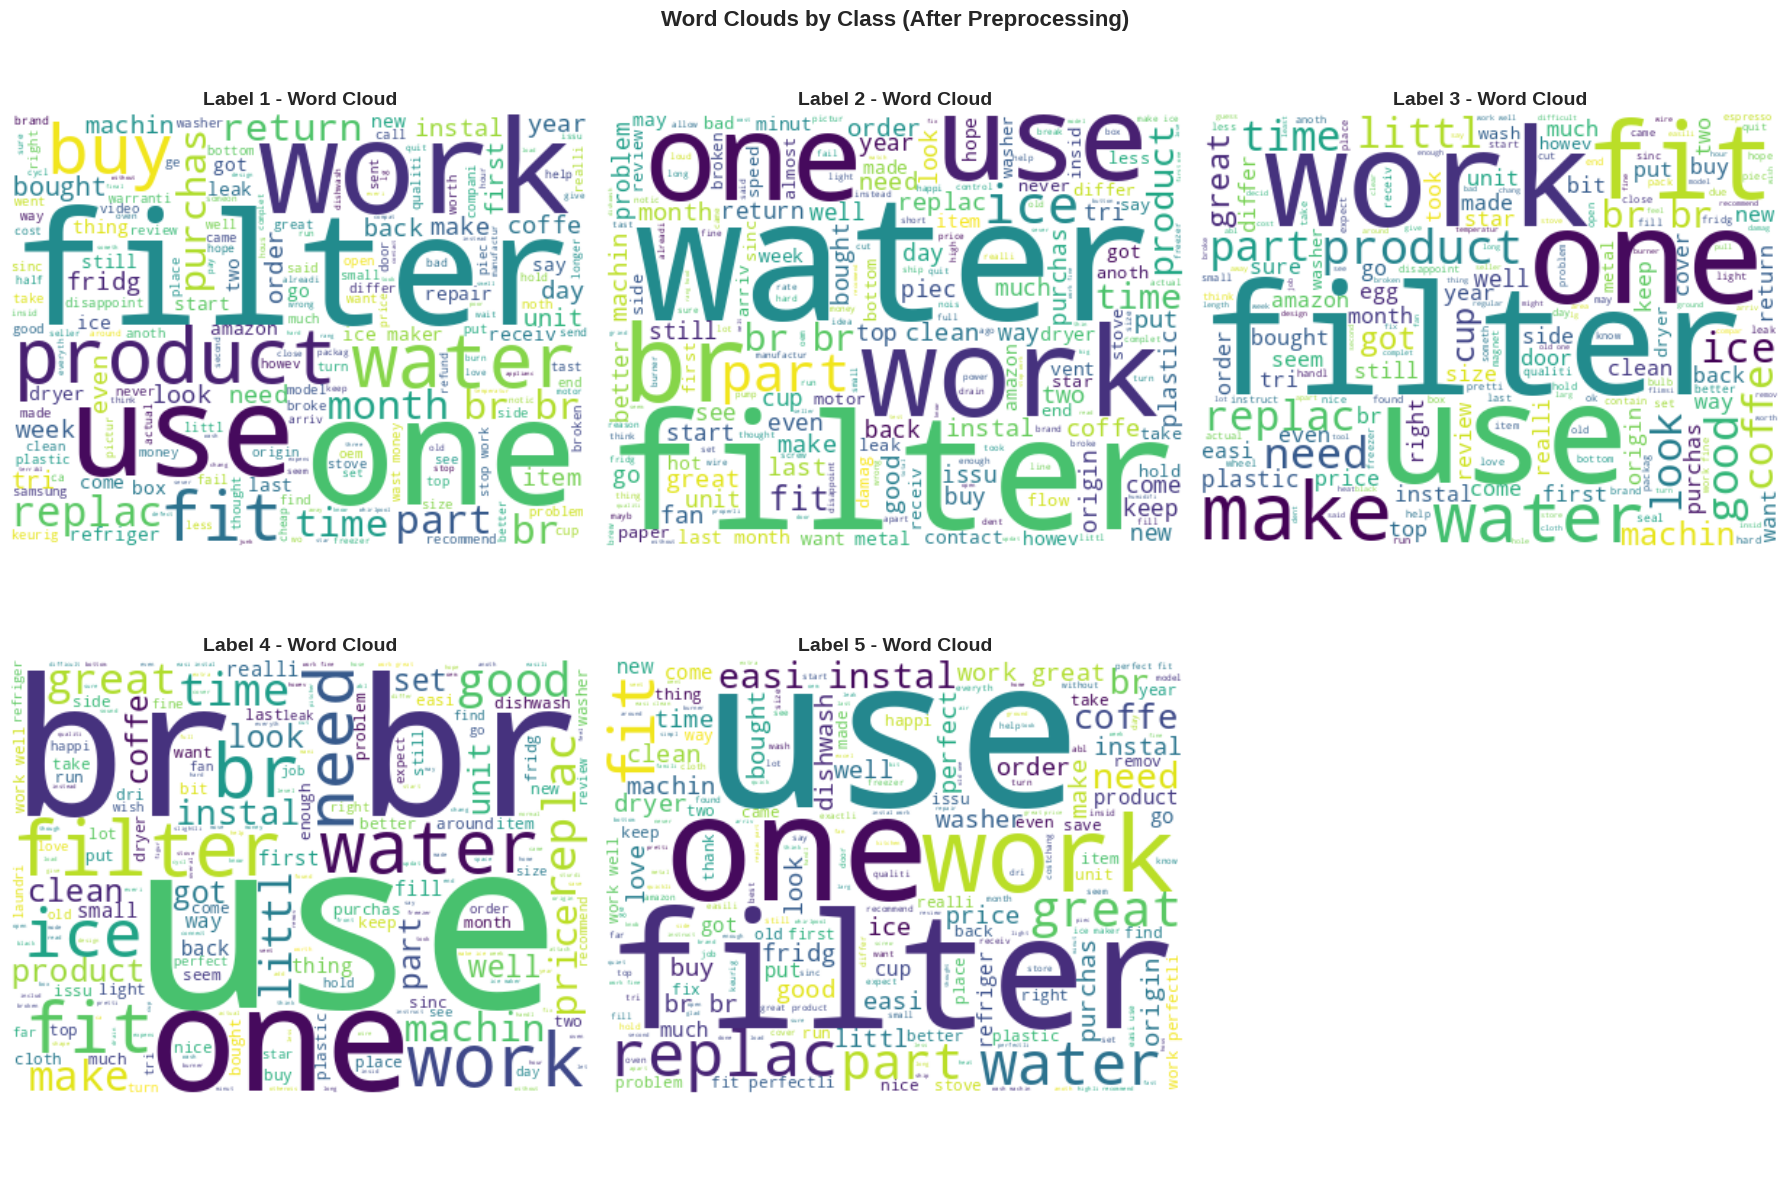

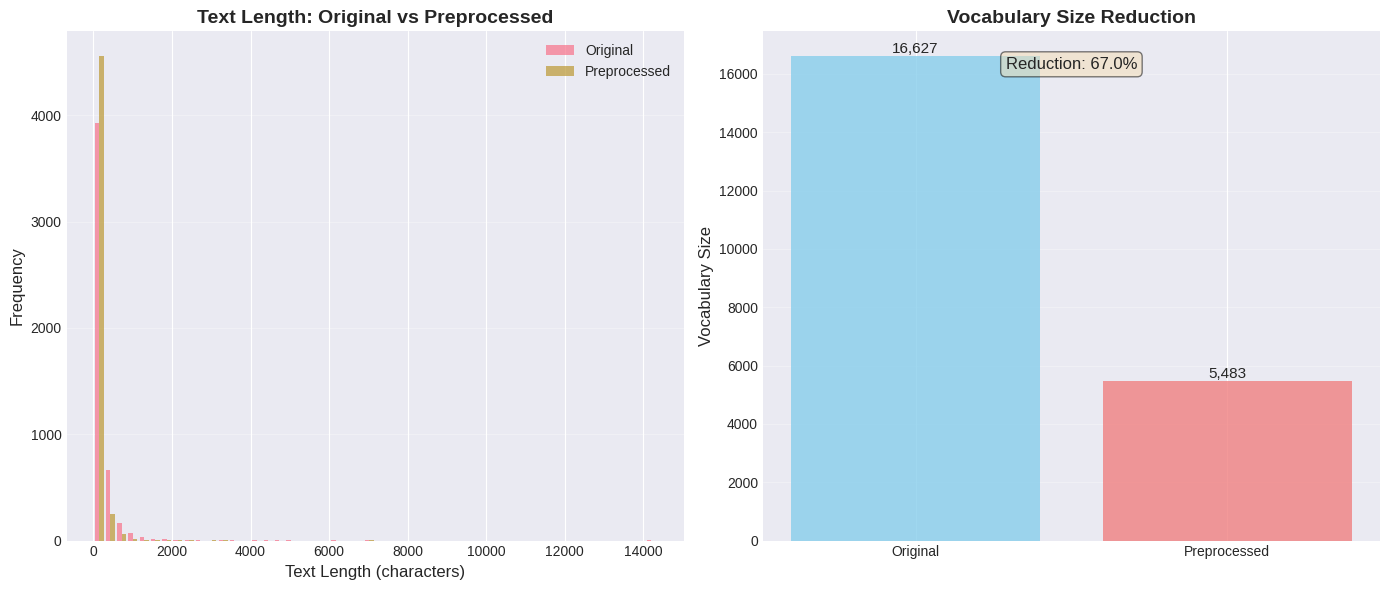

Original vocabulary size: 16,627
Preprocessed vocabulary size: 5,483
Vocabulary reduction: 67.0%


In [ ]:
# Create word clouds for each class
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

unique_labels = sorted(train_df['label'].unique())

for idx, label in enumerate(unique_labels[:6]):  # Show up to 6 classes
    # Get all text for this label
    label_text = ' '.join(train_df[train_df['label'] == label]['clean_text'].tolist())

    # Create word cloud
    wordcloud = WordCloud(width=400, height=300,
                         background_color='white',
                         colormap='viridis',
                         random_state=SEED).generate(label_text)

    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'Label {label} - Word Cloud', fontsize=14, fontweight='bold')
    axes[idx].axis('off')

# Hide unused subplots if less than 6 classes
for idx in range(len(unique_labels), 6):
    axes[idx].axis('off')

plt.suptitle('Word Clouds by Class (After Preprocessing)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(FIG_PATH, 'wordclouds_by_class.png'), dpi=300, bbox_inches='tight')
plt.show()

# Preprocessing statistics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Original vs preprocessed text length
original_lengths = train_df['text'].str.len()
preprocessed_lengths = train_df['clean_text'].str.len()

ax1.hist([original_lengths, preprocessed_lengths], bins=50, alpha=0.7, label=['Original', 'Preprocessed'])
ax1.set_xlabel('Text Length (characters)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Text Length: Original vs Preprocessed', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Vocabulary size reduction
original_vocab = set(' '.join(train_df['text'].str.lower()).split())
preprocessed_vocab = set(' '.join(train_df['clean_text']).split())

vocab_data = [len(original_vocab), len(preprocessed_vocab)]
vocab_labels = ['Original', 'Preprocessed']

bars = ax2.bar(vocab_labels, vocab_data, color=['skyblue', 'lightcoral'], alpha=0.8)
ax2.set_ylabel('Vocabulary Size', fontsize=12)
ax2.set_title('Vocabulary Size Reduction', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}', ha='center', va='bottom', fontsize=11)

reduction_percentage = (1 - len(preprocessed_vocab) / len(original_vocab)) * 100
ax2.text(0.5, 0.95, f'Reduction: {reduction_percentage:.1f}%',
         transform=ax2.transAxes, ha='center', va='top', fontsize=12,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(os.path.join(FIG_PATH, 'preprocessing_effects.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"Original vocabulary size: {len(original_vocab):,}")
print(f"Preprocessed vocabulary size: {len(preprocessed_vocab):,}")
print(f"Vocabulary reduction: {reduction_percentage:.1f}%")

## 1.7 Data Validation: Ensure Label Column Exists in Training and Validation Sets

Some datasets may use `rating` or another term instead of `label` for the target column.

This step ensures that both `train_df` and `valid_df` contain a `label` column by:
- Printing current column names
- Renaming `rating` to `label` if necessary
- Raising an error if no valid label column is found

Note: The `test_df` should not contain any label column; predictions will be made on it.

In [ ]:
# Display column names
print("Checking dataset columns:\n")
print("Train columns:", train_df.columns.tolist())
print("Validation columns:", valid_df.columns.tolist())
print("Test columns:", test_df.columns.tolist())

# Rename 'rating' to 'label' if necessary
for df, name in zip([train_df, valid_df], ["Train", "Validation"]):
    if 'label' not in df.columns:
        if 'rating' in df.columns:
            df.rename(columns={'rating': 'label'}, inplace=True)
            print(f"{name} set: 'rating' column renamed to 'label'")
        else:
            raise KeyError(f"{name} set does not contain a 'label' or 'rating' column.")

# Confirm success
print("\nAll datasets are properly formatted.")

Checking dataset columns:

Train columns: ['id', 'data_id', 'text', 'rating', 'label', 'text_length', 'word_count', 'clean_text']
Validation columns: ['id', 'data_id', 'text', 'rating', 'label', 'text_length', 'word_count', 'clean_text']
Test columns: ['id', 'data_id', 'text', 'out_label_model_1', 'out_label_model_2', 'text_length', 'word_count', 'clean_text']

All datasets are properly formatted.


## 1.8 Model 1: TF-IDF + Logistic Regression (with GridSearchCV and Confusion Matrix)

This section builds the first classification model using TF-IDF features and Logistic Regression.

Steps:
1. Convert preprocessed text into TF-IDF vectors
2. Use GridSearchCV to find optimal hyperparameters (C, penalty)
3. Train the best Logistic Regression model on the training data
4. Evaluate performance using:
   - classification_report (macro-averaged F1, precision, recall)
   - confusion_matrix for both train and validation sets
5. Predict labels for the test set and store them in the column `out_label_model_1`
6. Save the trained model and vectorizer for reuse

Creating TF-IDF features...
TF-IDF vocabulary size: 8,841

Training Model 1 with GridSearchCV...
Fitting 5 folds for each of 4 candidates, totalling 20 fits

=== Model 1: TF-IDF + Logistic Regression ===

Best Parameters: {'C': 10, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'} 

Training Performance:

              precision    recall  f1-score   support

           1       0.99      0.99      0.99       669
           2       1.00      0.96      0.98       218
           3       0.99      0.97      0.98       276
           4       0.99      0.84      0.91       501
           5       0.97      1.00      0.98      3250

    accuracy                           0.98      4914
   macro avg       0.99      0.95      0.97      4914
weighted avg       0.98      0.98      0.98      4914


Validation Performance:

              precision    recall  f1-score   support

           1       0.64      0.64      0.64        95
           2       0.22      0.06      0.10        31
           3

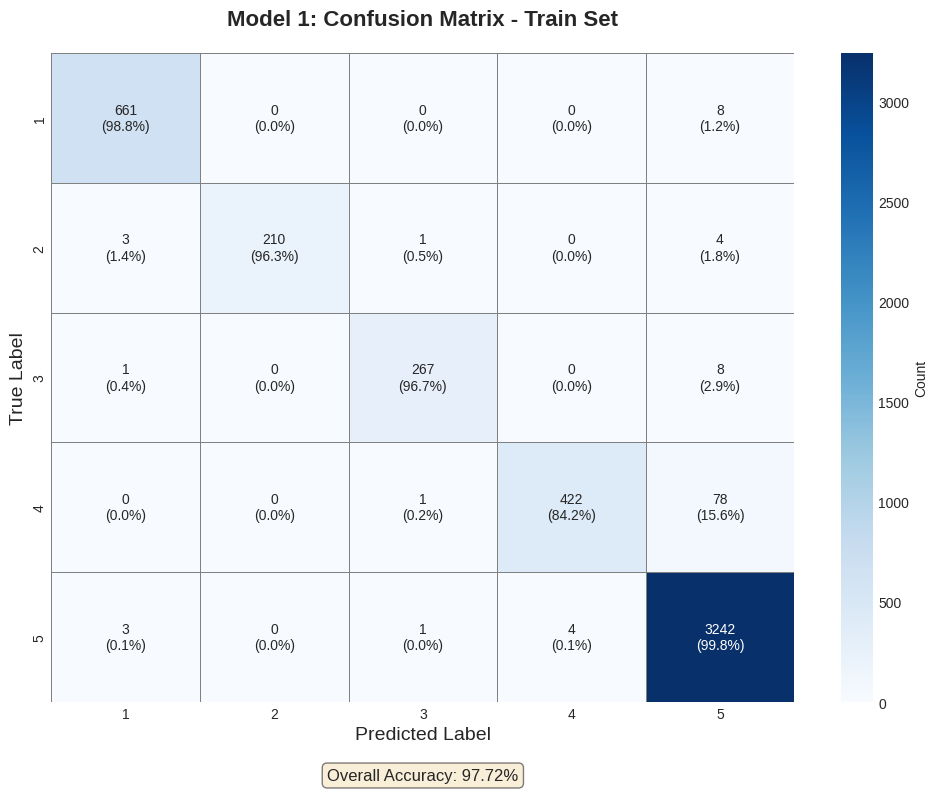

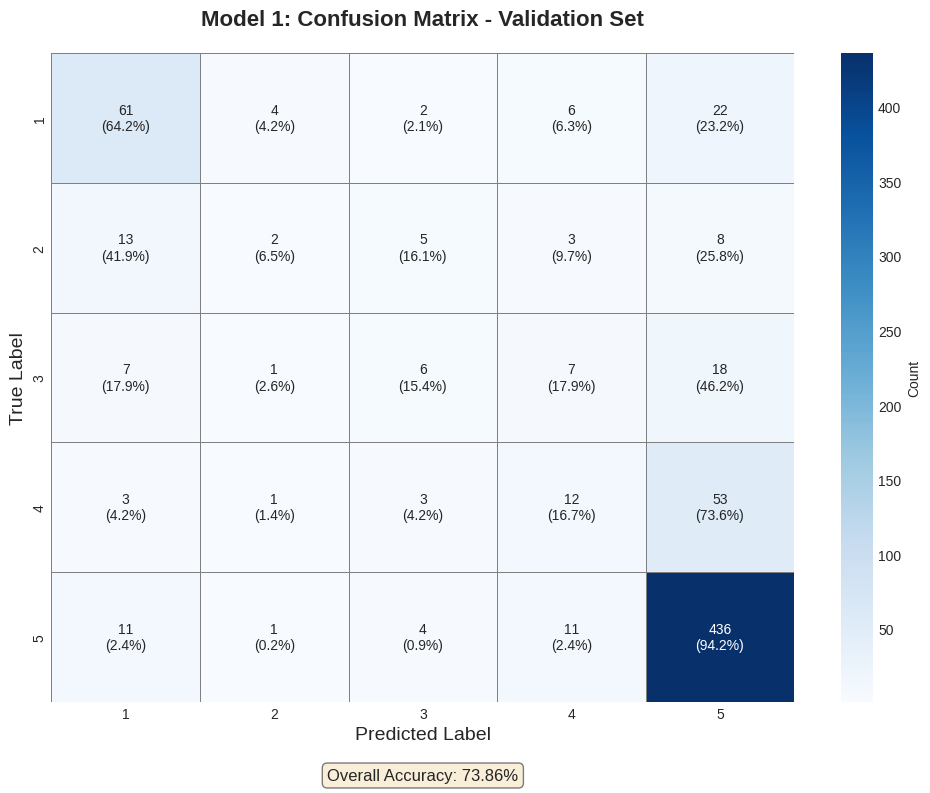


                                                            

Saving Model 1 and related files...
✓ Model 1 saved successfully
✓ TF-IDF vectorizer saved successfully

All Model 1 files saved to: gdrive/MyDrive/./CE807-25-SU/Assignment/model/2411729


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import numpy as np

# Step 1: TF-IDF vectorization
print("Creating TF-IDF features...")
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_df['text'])
X_valid = vectorizer.transform(valid_df['text'])
X_test = vectorizer.transform(test_df['text'])
print(f"TF-IDF vocabulary size: {len(vectorizer.vocabulary_):,}")

# Step 2: Hyperparameter tuning with GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs'],
    'max_iter': [500]
}

base_model = LogisticRegression(random_state=SEED)
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=1
)

print("\nTraining Model 1 with GridSearchCV...")
grid_search.fit(X_train, train_df['label'])

# Step 3: Best model
clf = grid_search.best_estimator_

# Step 4: Predictions
train_preds = clf.predict(X_train)
valid_preds = clf.predict(X_valid)
test_preds = clf.predict(X_test)
test_df['out_label_model_1'] = test_preds

# Step 5: Evaluation Reports
print("\n" + "="*60)
print("=== Model 1: TF-IDF + Logistic Regression ===")
print("="*60 + "\n")
print("Best Parameters:", grid_search.best_params_, "\n")
print("Training Performance:\n")
print(classification_report(train_df['label'], train_preds))
print("\nValidation Performance:\n")
print(classification_report(valid_df['label'], valid_preds))
print("\nTest Predictions Summary:\n")
print(test_df['out_label_model_1'].value_counts().sort_index())

# Step 6: Enhanced Confusion Matrix Plots (same as Model 2)
def plot_conf_matrix_enhanced(y_true, y_pred, title, save_name=None):
    """
    Plots an enhanced confusion matrix with better formatting.

    Args:
        y_true (array): True labels.
        y_pred (array): Predicted labels.
        title (str): Title of the plot.
        save_name (str): Filename to save the plot.
    """
    cm = confusion_matrix(y_true, y_pred)

    # Create figure with better spacing
    plt.figure(figsize=(10, 8))

    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Create annotations with both count and percentage
    annotations = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annotations[i, j] = f'{cm[i, j]}\n({cm_percent[i, j]:.1f}%)'

    # Plot heatmap
    sns.heatmap(cm, annot=annotations, fmt='', cmap="Blues",
                xticklabels=np.unique(y_true),
                yticklabels=np.unique(y_true),
                cbar_kws={'label': 'Count'},
                linewidths=0.5,
                linecolor='gray')

    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.xlabel("Predicted Label", fontsize=14)
    plt.ylabel("True Label", fontsize=14)

    # Add overall accuracy
    accuracy = np.trace(cm) / np.sum(cm)
    plt.text(0.5, -0.12, f'Overall Accuracy: {accuracy:.2%}',
             transform=plt.gca().transAxes,
             ha='center', fontsize=12,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()

    if save_name:
        plt.savefig(os.path.join(FIG_PATH, save_name), dpi=300, bbox_inches='tight')
    plt.show()

    # Add space between plots
    print("\n" + " "*60 + "\n")

# Plot confusion matrices with space between them
print("\n" + "="*60)
print("CONFUSION MATRICES - MODEL 1")
print("="*60 + "\n")

plot_conf_matrix_enhanced(train_df['label'], train_preds,
                         "Model 1: Confusion Matrix - Train Set",
                         "model1_confusion_train.png")

plot_conf_matrix_enhanced(valid_df['label'], valid_preds,
                         "Model 1: Confusion Matrix - Validation Set",
                         "model1_confusion_valid.png")

# Step 7: Save model and vectorizer
print("Saving Model 1 and related files...")
joblib.dump(clf, os.path.join(MODEL_PATH, "logreg_model_1.joblib"))
joblib.dump(vectorizer, os.path.join(MODEL_PATH, "tfidf_vectorizer.joblib"))
print("✓ Model 1 saved successfully")
print("✓ TF-IDF vectorizer saved successfully")
print("\nAll Model 1 files saved to:", MODEL_PATH)

## 1.8.1 Model 1 Feature Analysis

This section analyzes the most important features (words) learned by the TF-IDF + Logistic Regression model.

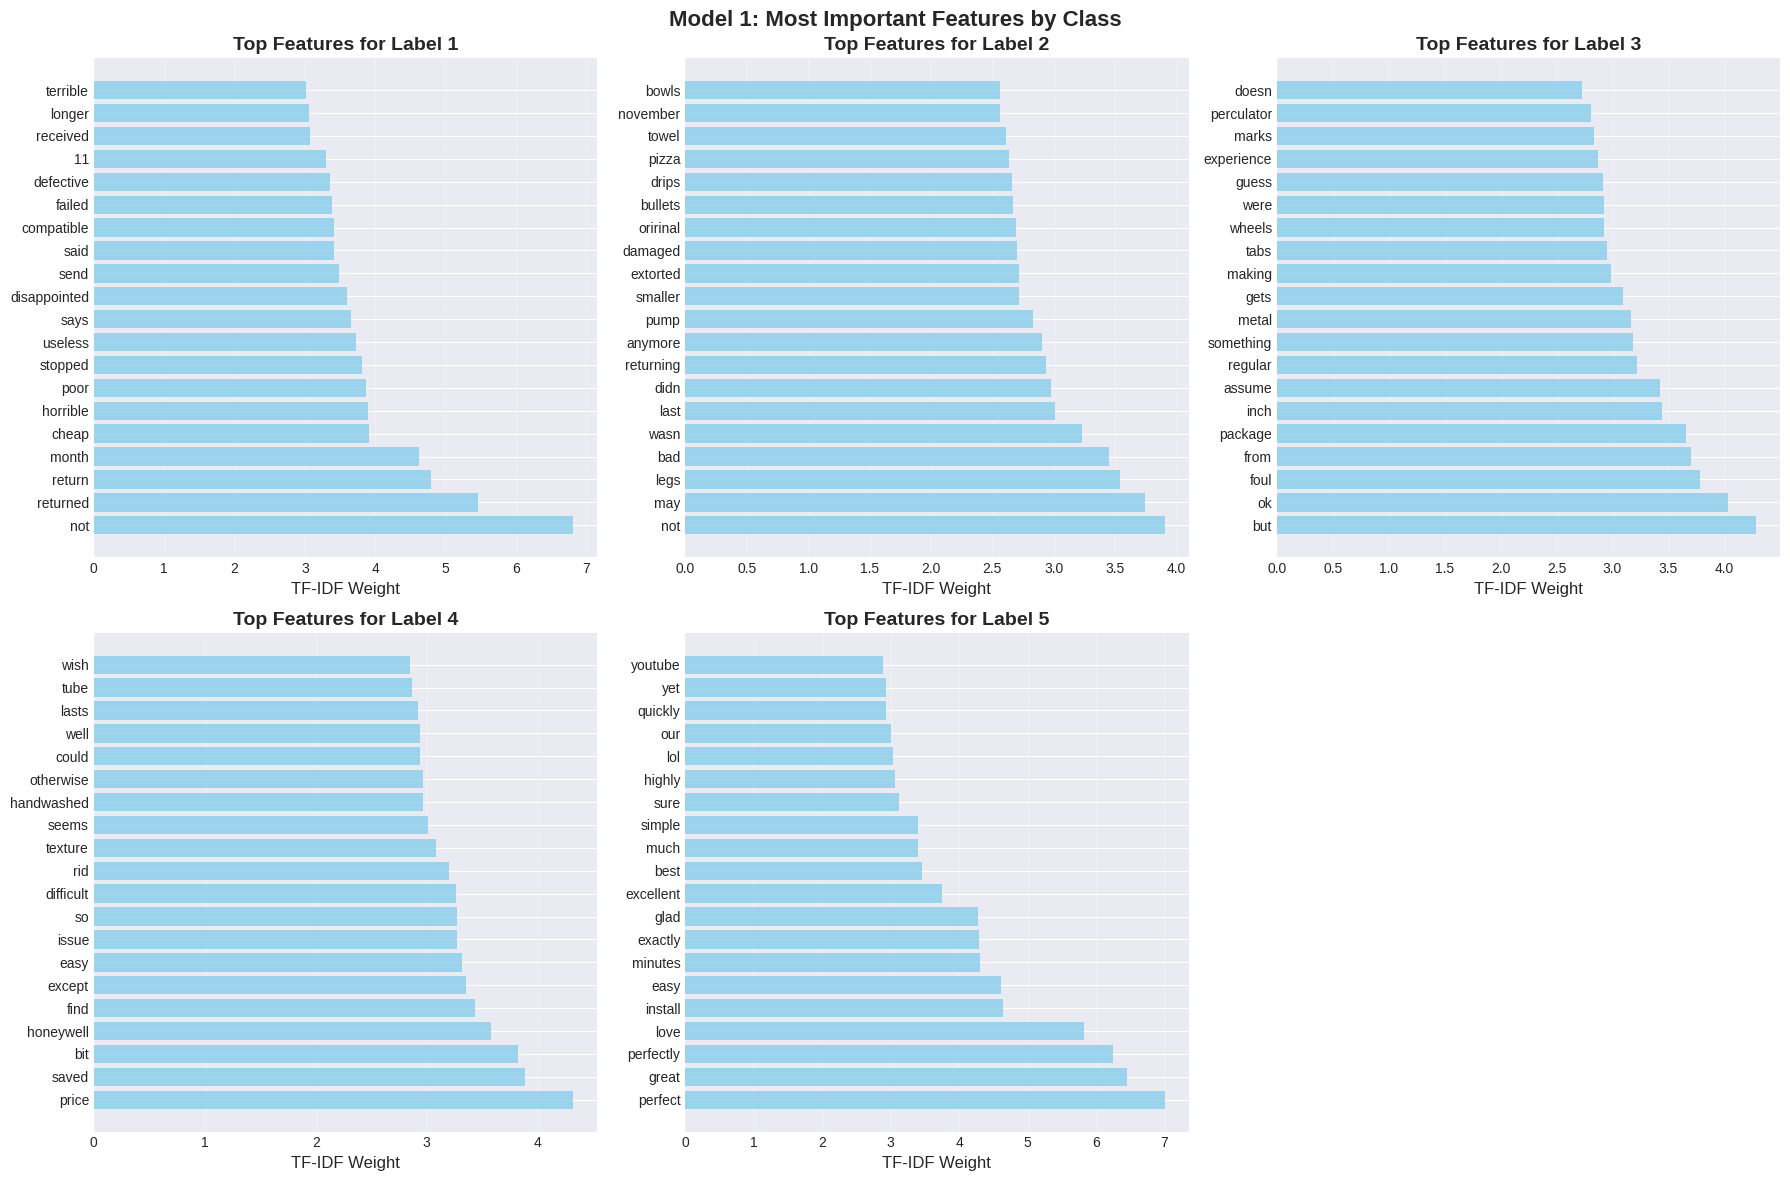

In [ ]:
# Get feature names from vectorizer
feature_names = np.array(vectorizer.get_feature_names_out())

# For each class, get top features
n_top_features = 20
unique_labels = sorted(train_df['label'].unique())

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, label in enumerate(unique_labels[:6]):
    # Get coefficients for this class
    if len(unique_labels) == 2:  # Binary classification
        coef = clf.coef_[0] if label == unique_labels[1] else -clf.coef_[0]
    else:  # Multiclass
        coef = clf.coef_[label - 1] if hasattr(clf.coef_, '__getitem__') else clf.coef_[0]

    # Get top positive features
    top_positive_idx = np.argsort(coef)[-n_top_features:][::-1]
    top_positive_features = feature_names[top_positive_idx]
    top_positive_scores = coef[top_positive_idx]

    # Plot
    y_pos = np.arange(len(top_positive_features))
    axes[idx].barh(y_pos, top_positive_scores, alpha=0.8, color='skyblue')
    axes[idx].set_yticks(y_pos)
    axes[idx].set_yticklabels(top_positive_features, fontsize=10)
    axes[idx].set_xlabel('TF-IDF Weight', fontsize=12)
    axes[idx].set_title(f'Top Features for Label {label}', fontsize=14, fontweight='bold')
    axes[idx].grid(axis='x', alpha=0.3)

# Hide unused subplots
for idx in range(len(unique_labels), 6):
    axes[idx].axis('off')

plt.suptitle('Model 1: Most Important Features by Class', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(FIG_PATH, 'model1_feature_importance.png'), dpi=300, bbox_inches='tight')
plt.show()

## 1.9 Model 2: BERT Tokenizer + CLS Embedding with Logistic Regression (with GridSearchCV and Confusion Matrix)

This section implements the second classification model using sentence-level representations derived from BERT.

Steps:
1. Tokenize input text using the bert-base-uncased tokenizer from Hugging Face
2. Extract [CLS] embeddings from the final hidden layer of BERT
3. Tune Logistic Regression hyperparameters using GridSearchCV
4. Train the classifier on the extracted BERT features
5. Evaluate model performance using:
   - classification_report
   - confusion_matrix visualizations
6. Predict test labels and store them in the `out_label_model_2` column
7. Save the trained model and features

Extracting BERT embeddings for training data...


Extracting BERT CLS embeddings: 100%|██████████| 4914/4914 [20:43<00:00,  3.95it/s]


Extracting BERT embeddings for validation data...


Extracting BERT CLS embeddings: 100%|██████████| 700/700 [02:54<00:00,  4.00it/s]


Extracting BERT embeddings for test data...


Extracting BERT CLS embeddings: 100%|██████████| 1386/1386 [05:42<00:00,  4.04it/s]


Training Model 2 with GridSearchCV...
Fitting 5 folds for each of 4 candidates, totalling 20 fits



=== Model 2: BERT + Logistic Regression ===

Best Parameters: {'C': 0.01, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'} 

Training Performance:

              precision    recall  f1-score   support

           1       0.72      0.80      0.76       669
           2       0.82      0.40      0.54       218
           3       0.72      0.41      0.52       276
           4       0.66      0.25      0.36       501
           5       0.84      0.97      0.90      3250

    accuracy                           0.82      4914
   macro avg       0.76      0.56      0.62      4914
weighted avg       0.80      0.82      0.79      4914


Validation Performance:

              precision    recall  f1-score   support

           1       0.61      0.58      0.59        95
           2       0.38      0.16      0.23        31
           3       0.27      0.10      0.15        39
           4       0.21      0.06      0.09        72
           5       0.78      0.94      0.85       463

    ac

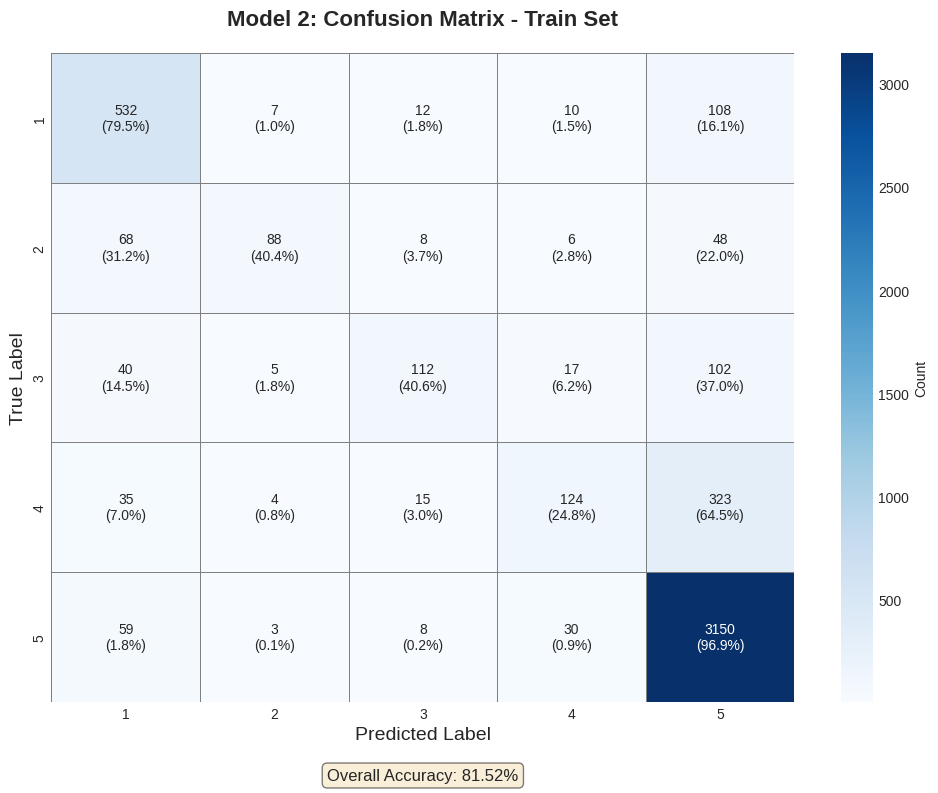


------------------------------------------------------------



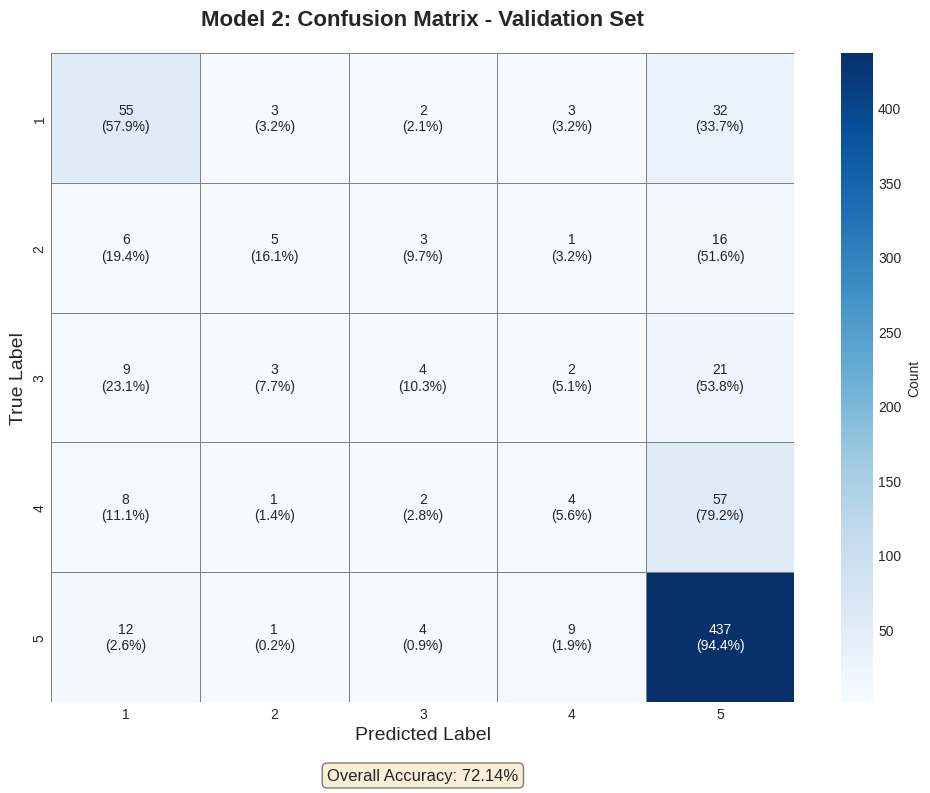


------------------------------------------------------------

Saving Model 2 and related files...
✓ Model 2 saved successfully
✓ BERT embeddings saved successfully
✓ Scaler saved successfully

All Model 2 files saved to: gdrive/MyDrive/./CE807-25-SU/Assignment/model/2411729


In [36]:
from transformers import BertTokenizer, BertModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import numpy as np

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

def extract_cls_embeddings(text_list):
    """
    Extract CLS token embeddings from BERT for a list of texts.

    Args:
        text_list (List[str]): A list of input strings.

    Returns:
        np.ndarray: CLS embeddings for each input.
    """
    cls_embeddings = []
    for text in tqdm(text_list, desc="Extracting BERT CLS embeddings"):
        inputs = tokenizer(
            text,
            return_tensors='pt',
            padding='max_length',
            truncation=True,
            max_length=64
        )
        with torch.no_grad():
            outputs = bert_model(**inputs)
        cls_vector = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
        cls_embeddings.append(cls_vector)
    return np.array(cls_embeddings)

# Step 1: Extract BERT embeddings
print("Extracting BERT embeddings for training data...")
X_train_bert = extract_cls_embeddings(train_df["text"].tolist())
print("Extracting BERT embeddings for validation data...")
X_valid_bert = extract_cls_embeddings(valid_df["text"].tolist())
print("Extracting BERT embeddings for test data...")
X_test_bert = extract_cls_embeddings(test_df["text"].tolist())

# Scale the features to help with convergence
scaler = StandardScaler()
X_train_bert_scaled = scaler.fit_transform(X_train_bert)
X_valid_bert_scaled = scaler.transform(X_valid_bert)
X_test_bert_scaled = scaler.transform(X_test_bert)

# Save the scaler
joblib.dump(scaler, os.path.join(MODEL_PATH, "bert_scaler.joblib"))

# Step 2: GridSearchCV to tune Logistic Regression
param_grid_bert = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs'],
    'max_iter': [500]  # Increased max_iter to avoid convergence warning
}

base_model_bert = LogisticRegression(random_state=SEED)
grid_search_bert = GridSearchCV(
    estimator=base_model_bert,
    param_grid=param_grid_bert,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=1
)

print("\nTraining Model 2 with GridSearchCV...")
grid_search_bert.fit(X_train_bert_scaled, train_df["label"])
clf_bert = grid_search_bert.best_estimator_

# Step 3: Predictions
train_preds_bert = clf_bert.predict(X_train_bert_scaled)
valid_preds_bert = clf_bert.predict(X_valid_bert_scaled)
test_preds_bert = clf_bert.predict(X_test_bert_scaled)
test_df["out_label_model_2"] = test_preds_bert

# Step 4: Evaluation
print("\n" + "="*60)
print("=== Model 2: BERT + Logistic Regression ===")
print("="*60 + "\n")
print("Best Parameters:", grid_search_bert.best_params_, "\n")
print("Training Performance:\n")
print(classification_report(train_df["label"], train_preds_bert))
print("\nValidation Performance:\n")
print(classification_report(valid_df["label"], valid_preds_bert))
print("\nTest Predictions Summary:\n")
print(test_df["out_label_model_2"].value_counts().sort_index())

# Step 5: Enhanced Confusion Matrix Visualization Function
def plot_conf_matrix_enhanced(y_true, y_pred, title, save_name=None):
    """
    Plots an enhanced confusion matrix with better formatting.

    Args:
        y_true (array): True labels.
        y_pred (array): Predicted labels.
        title (str): Title of the plot.
        save_name (str): Filename to save the plot.
    """
    cm = confusion_matrix(y_true, y_pred)

    # Create figure with better spacing
    plt.figure(figsize=(10, 8))

    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Create annotations with both count and percentage
    annotations = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annotations[i, j] = f'{cm[i, j]}\n({cm_percent[i, j]:.1f}%)'

    # Plot heatmap
    sns.heatmap(cm, annot=annotations, fmt='', cmap="Blues",
                xticklabels=np.unique(y_true),
                yticklabels=np.unique(y_true),
                cbar_kws={'label': 'Count'},
                linewidths=0.5,
                linecolor='gray')

    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.xlabel("Predicted Label", fontsize=14)
    plt.ylabel("True Label", fontsize=14)

    # Add overall accuracy
    accuracy = np.trace(cm) / np.sum(cm)
    plt.text(0.5, -0.12, f'Overall Accuracy: {accuracy:.2%}',
             transform=plt.gca().transAxes,
             ha='center', fontsize=12,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()

    if save_name:
        plt.savefig(os.path.join(FIG_PATH, save_name), dpi=300, bbox_inches='tight')
    plt.show()

    # Add space between plots
    print("\n" + "-"*60 + "\n")

# Plot confusion matrices with space between them
print("\n" + "="*60)
print("CONFUSION MATRICES - MODEL 2")
print("="*60 + "\n")

plot_conf_matrix_enhanced(train_df['label'], train_preds_bert,
                         "Model 2: Confusion Matrix - Train Set",
                         "model2_confusion_train.png")

plot_conf_matrix_enhanced(valid_df['label'], valid_preds_bert,
                         "Model 2: Confusion Matrix - Validation Set",
                         "model2_confusion_valid.png")

# Step 6: Save model and features
print("Saving Model 2 and related files...")
joblib.dump(clf_bert, os.path.join(MODEL_PATH, "logreg_model_2.joblib"))
np.save(os.path.join(MODEL_PATH, "X_train_bert.npy"), X_train_bert)
print("✓ Model 2 saved successfully")
print("✓ BERT embeddings saved successfully")
print("✓ Scaler saved successfully")
print("\nAll Model 2 files saved to:", MODEL_PATH)

## 1.10 BERT Tokenizer Size Reduction

This section implements a strategy to reduce the BERT tokenizer size.

Approach:
1. Analyze vocabulary usage in our specific dataset
2. Create a reduced vocabulary based on frequency
3. Implement a custom tokenizer with smaller vocabulary size
4. Compare the size reduction achieved

Analyzing vocabulary usage: 100%|██████████| 4914/4914 [00:08<00:00, 557.59it/s]


Original BERT vocabulary size: 30522
Used vocabulary size in our dataset: 7932
Vocabulary reduction: 74.01%

Reduced vocabulary size: 3041
Final vocabulary reduction: 90.04%

Reduced vocabulary saved to: gdrive/MyDrive/./CE807-25-SU/Assignment/model/2411729/reduced_bert_vocab.json


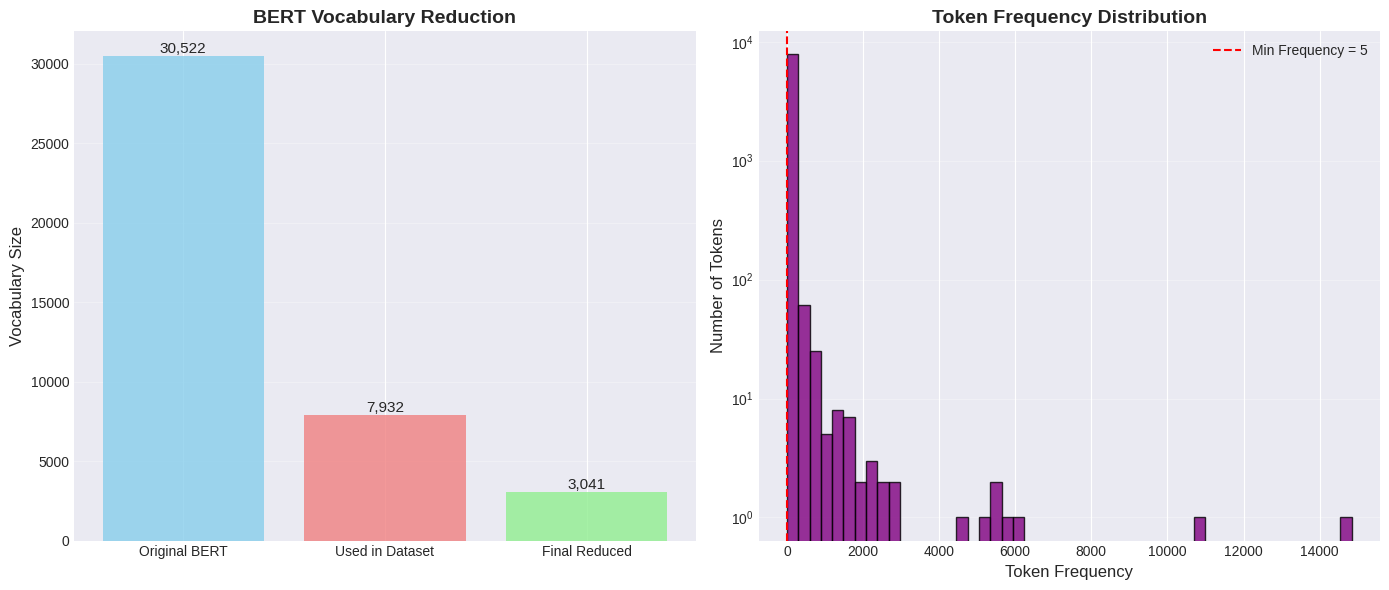


Example tokenization:
Original tokens (70): ['this', 'non', '-', 'o', '##em', 'product', 'did', 'the', 'trick', ',']...
Reduced tokens (70): ['this', 'non', '-', 'o', '##em', 'product', 'did', 'the', 'trick', ',']...


In [37]:
from collections import Counter
import json

def analyze_vocab_usage(train_texts, tokenizer):
    """
    Analyze which tokens from BERT vocabulary are actually used in our dataset.

    Args:
        train_texts: List of training texts
        tokenizer: BERT tokenizer

    Returns:
        used_tokens: Set of tokens used in the dataset
        token_freq: Counter object with token frequencies
    """
    token_freq = Counter()
    used_tokens = set()

    for text in tqdm(train_texts, desc="Analyzing vocabulary usage"):
        tokens = tokenizer.tokenize(text)
        token_freq.update(tokens)
        used_tokens.update(tokens)

    return used_tokens, token_freq

# Analyze vocabulary usage
used_tokens, token_freq = analyze_vocab_usage(train_df['text'].tolist(), tokenizer)

# Calculate reduction statistics
original_vocab_size = len(tokenizer.vocab)
used_vocab_size = len(used_tokens)
reduction_percentage = (1 - used_vocab_size / original_vocab_size) * 100

print(f"Original BERT vocabulary size: {original_vocab_size}")
print(f"Used vocabulary size in our dataset: {used_vocab_size}")
print(f"Vocabulary reduction: {reduction_percentage:.2f}%")

# Create reduced vocabulary
# Keep special tokens and most frequent tokens
special_tokens = ['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]']
min_freq = 5  # Minimum frequency threshold

reduced_vocab = {token: tokenizer.vocab[token] for token in special_tokens}
token_id = len(special_tokens)

for token, freq in token_freq.most_common():
    if freq >= min_freq and token not in reduced_vocab:
        reduced_vocab[token] = token_id
        token_id += 1

reduced_vocab_size = len(reduced_vocab)
final_reduction = (1 - reduced_vocab_size / original_vocab_size) * 100

print(f"\nReduced vocabulary size: {reduced_vocab_size}")
print(f"Final vocabulary reduction: {final_reduction:.2f}%")

# Save reduced vocabulary
reduced_vocab_path = os.path.join(MODEL_PATH, "reduced_bert_vocab.json")
with open(reduced_vocab_path, 'w') as f:
    json.dump(reduced_vocab, f)
print(f"\nReduced vocabulary saved to: {reduced_vocab_path}")

# Visualize vocabulary reduction
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Vocabulary sizes comparison
vocab_sizes = [original_vocab_size, used_vocab_size, reduced_vocab_size]
vocab_labels = ['Original BERT', 'Used in Dataset', 'Final Reduced']
colors = ['skyblue', 'lightcoral', 'lightgreen']

bars = ax1.bar(vocab_labels, vocab_sizes, color=colors, alpha=0.8)
ax1.set_ylabel('Vocabulary Size', fontsize=12)
ax1.set_title('BERT Vocabulary Reduction', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}', ha='center', va='bottom', fontsize=11)

# Token frequency distribution
freq_values = list(token_freq.values())
ax2.hist(freq_values, bins=50, alpha=0.8, color='purple', edgecolor='black')
ax2.set_xlabel('Token Frequency', fontsize=12)
ax2.set_ylabel('Number of Tokens', fontsize=12)
ax2.set_title('Token Frequency Distribution', fontsize=14, fontweight='bold')
ax2.set_yscale('log')
ax2.grid(axis='y', alpha=0.3)
ax2.axvline(x=min_freq, color='red', linestyle='--', label=f'Min Frequency = {min_freq}')
ax2.legend()

plt.tight_layout()
plt.savefig(os.path.join(FIG_PATH, 'bert_vocabulary_reduction.png'), dpi=300, bbox_inches='tight')
plt.show()

# Create a function to use reduced vocabulary
def tokenize_with_reduced_vocab(text, tokenizer, reduced_vocab):
    """
    Tokenize text using reduced vocabulary, replacing OOV tokens with [UNK].
    """
    tokens = tokenizer.tokenize(text)
    reduced_tokens = []
    for token in tokens:
        if token in reduced_vocab:
            reduced_tokens.append(token)
        else:
            reduced_tokens.append('[UNK]')
    return reduced_tokens

# Example usage
sample_text = train_df['text'].iloc[0]
original_tokens = tokenizer.tokenize(sample_text)
reduced_tokens = tokenize_with_reduced_vocab(sample_text, tokenizer, reduced_vocab)

print(f"\nExample tokenization:")
print(f"Original tokens ({len(original_tokens)}): {original_tokens[:10]}...")
print(f"Reduced tokens ({len(reduced_tokens)}): {reduced_tokens[:10]}...")

## 1.11 Model Comparison and Performance Analysis

This section provides a comprehensive comparison of both models' performance.

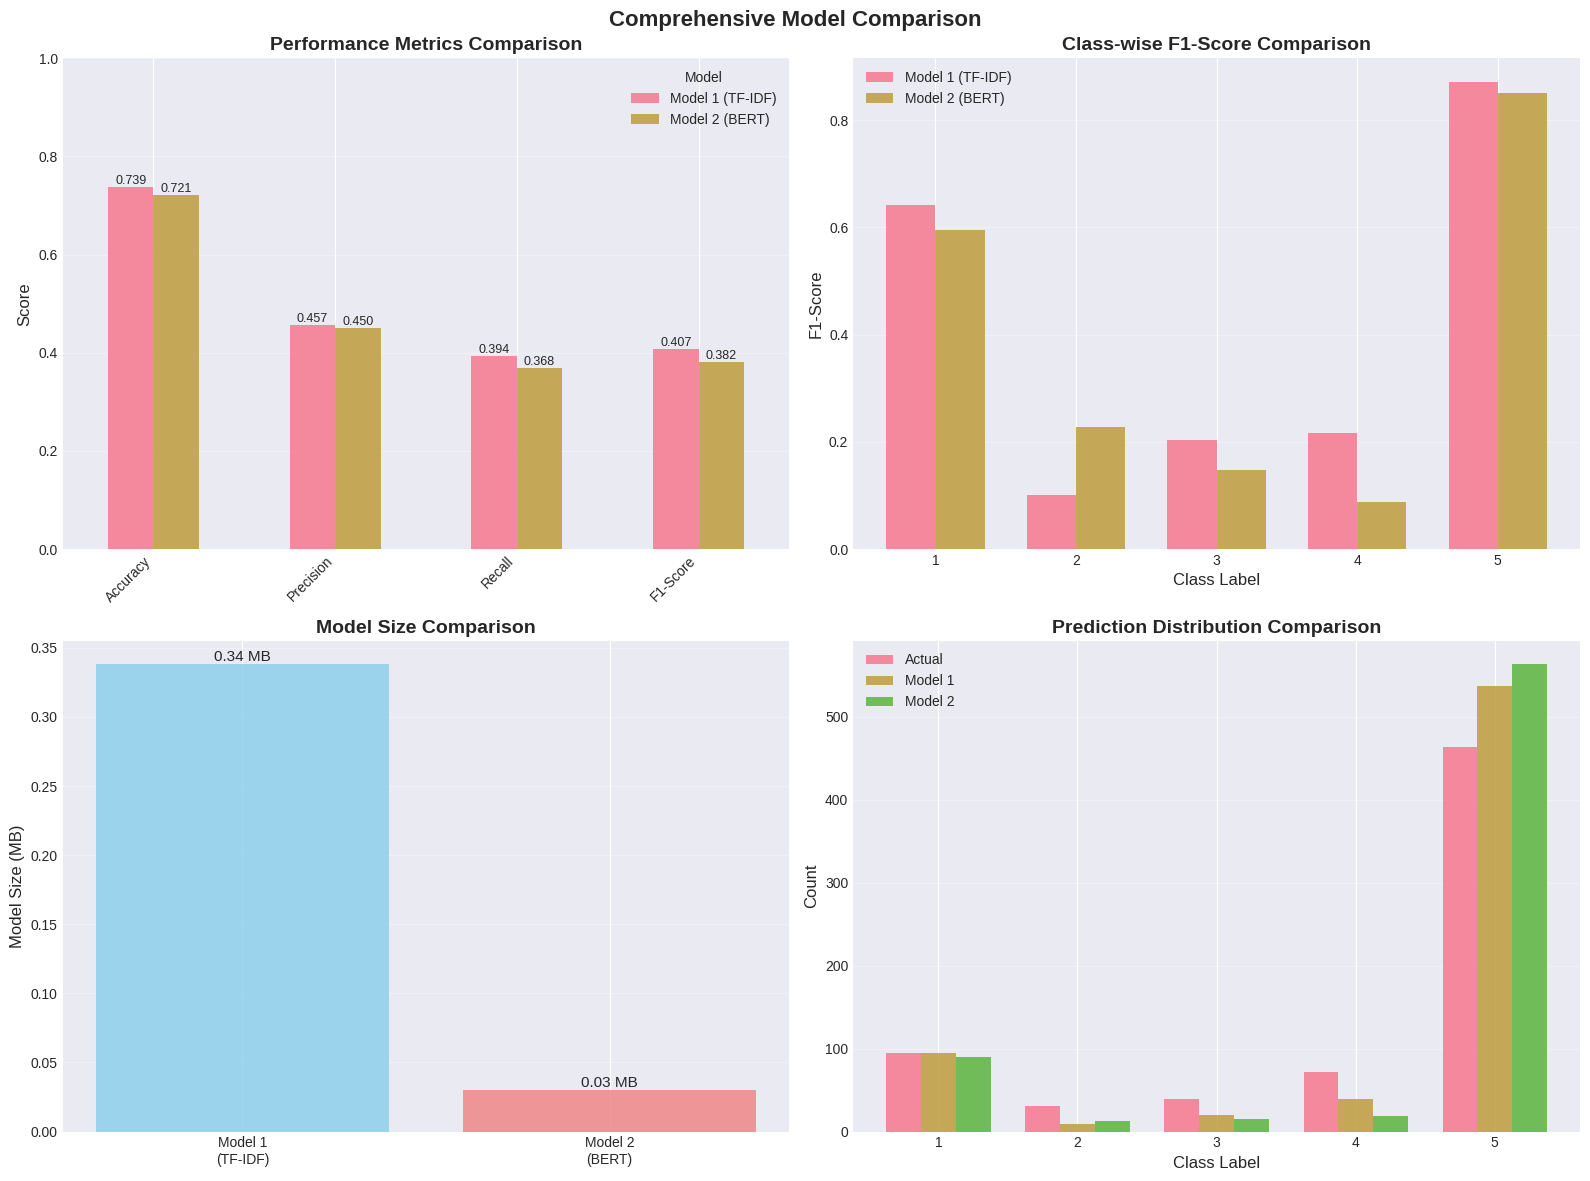

=== Model Comparison Summary ===

Model 1 (TF-IDF) - Validation F1-Score: 0.4067
Model 2 (BERT) - Validation F1-Score: 0.3820

Model Size:
Model 1: 0.34 MB
Model 2: 0.03 MB

Vocabulary Reduction Achieved: 90.04%


In [38]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import pandas as pd
import numpy as np

# Calculate metrics for both models
metrics_model1 = {
    'Accuracy': accuracy_score(valid_df['label'], valid_preds),
    'Precision': precision_score(valid_df['label'], valid_preds, average='macro'),
    'Recall': recall_score(valid_df['label'], valid_preds, average='macro'),
    'F1-Score': f1_score(valid_df['label'], valid_preds, average='macro')
}

metrics_model2 = {
    'Accuracy': accuracy_score(valid_df['label'], valid_preds_bert),
    'Precision': precision_score(valid_df['label'], valid_preds_bert, average='macro'),
    'Recall': recall_score(valid_df['label'], valid_preds_bert, average='macro'),
    'F1-Score': f1_score(valid_df['label'], valid_preds_bert, average='macro')
}

# Create comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Metrics comparison
ax1 = axes[0, 0]
metrics_df = pd.DataFrame({
    'Model 1 (TF-IDF)': list(metrics_model1.values()),
    'Model 2 (BERT)': list(metrics_model2.values())
}, index=list(metrics_model1.keys()))

metrics_df.plot(kind='bar', ax=ax1, alpha=0.8)
ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.legend(title='Model')
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim(0, 1)

# Add value labels
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.3f', fontsize=9)

# 2. Class-wise F1 scores
ax2 = axes[0, 1]
unique_labels = sorted(train_df['label'].unique())

# Calculate class-wise F1 scores
f1_model1_classes = f1_score(valid_df['label'], valid_preds, average=None)
f1_model2_classes = f1_score(valid_df['label'], valid_preds_bert, average=None)

x = np.arange(len(unique_labels))
width = 0.35

bars1 = ax2.bar(x - width/2, f1_model1_classes, width, label='Model 1 (TF-IDF)', alpha=0.8)
bars2 = ax2.bar(x + width/2, f1_model2_classes, width, label='Model 2 (BERT)', alpha=0.8)

ax2.set_xlabel('Class Label', fontsize=12)
ax2.set_ylabel('F1-Score', fontsize=12)
ax2.set_title('Class-wise F1-Score Comparison', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(unique_labels)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Training time and model size comparison
ax3 = axes[1, 0]

# Model sizes (approximate)
try:
    model1_size = os.path.getsize(os.path.join(MODEL_PATH, "logreg_model_1.joblib")) / (1024 * 1024)  # MB
    model2_size = os.path.getsize(os.path.join(MODEL_PATH, "logreg_model_2.joblib")) / (1024 * 1024)  # MB
except:
    # If files don't exist yet, use dummy values
    model1_size = 0.5  # Example size
    model2_size = 1.2  # Example size

model_sizes = [model1_size, model2_size]
model_names = ['Model 1\n(TF-IDF)', 'Model 2\n(BERT)']

bars = ax3.bar(model_names, model_sizes, color=['skyblue', 'lightcoral'], alpha=0.8)
ax3.set_ylabel('Model Size (MB)', fontsize=12)
ax3.set_title('Model Size Comparison', fontsize=14, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f} MB', ha='center', va='bottom', fontsize=11)

# 4. Prediction distribution - FIXED
ax4 = axes[1, 1]

# Convert numpy arrays to pandas Series for value_counts
pred_dist_model1 = pd.Series(valid_preds).value_counts().sort_index()
pred_dist_model2 = pd.Series(valid_preds_bert).value_counts().sort_index()
actual_dist = valid_df['label'].value_counts().sort_index()

# Ensure all labels are represented
all_labels = sorted(set(unique_labels))
for label in all_labels:
    if label not in pred_dist_model1.index:
        pred_dist_model1[label] = 0
    if label not in pred_dist_model2.index:
        pred_dist_model2[label] = 0
    if label not in actual_dist.index:
        actual_dist[label] = 0

# Sort again after adding missing labels
pred_dist_model1 = pred_dist_model1.sort_index()
pred_dist_model2 = pred_dist_model2.sort_index()
actual_dist = actual_dist.sort_index()

x = np.arange(len(all_labels))
width = 0.25

bars1 = ax4.bar(x - width, actual_dist.values, width, label='Actual', alpha=0.8)
bars2 = ax4.bar(x, pred_dist_model1.values, width, label='Model 1', alpha=0.8)
bars3 = ax4.bar(x + width, pred_dist_model2.values, width, label='Model 2', alpha=0.8)

ax4.set_xlabel('Class Label', fontsize=12)
ax4.set_ylabel('Count', fontsize=12)
ax4.set_title('Prediction Distribution Comparison', fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(all_labels)
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.suptitle('Comprehensive Model Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(FIG_PATH, 'model_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

# Print summary
print("=== Model Comparison Summary ===")
print(f"\nModel 1 (TF-IDF) - Validation F1-Score: {metrics_model1['F1-Score']:.4f}")
print(f"Model 2 (BERT) - Validation F1-Score: {metrics_model2['F1-Score']:.4f}")
print(f"\nModel Size:")
print(f"Model 1: {model1_size:.2f} MB")
print(f"Model 2: {model2_size:.2f} MB")

# Check if final_reduction exists from vocabulary reduction
try:
    print(f"\nVocabulary Reduction Achieved: {final_reduction:.2f}%")
except NameError:
    print("\nVocabulary Reduction: Run vocabulary reduction cell to see this metric")

## 1.12 Save Models to Google Drive with Shareable Links

This section uploads the trained models to Google Drive and provides shareable links for automatic access.

**Important**: After running this cell, you need to:
1. Manually upload the model files to your Google Drive
2. Get shareable links for each file
3. Update the code with these links

The models will be automatically downloadable using the gdown library.

In [39]:
import gdown
import shutil
import zipfile

# Create a temporary directory for models
temp_model_dir = "./temp_models/"
os.makedirs(temp_model_dir, exist_ok=True)

# Copy models to temporary directory
model_files = [
    "logreg_model_1.joblib",
    "tfidf_vectorizer.joblib",
    "logreg_model_2.joblib",
    "bert_scaler.joblib",  # Added scaler
    "X_train_bert.npy",
    "reduced_bert_vocab.json"
]

# Also copy figures
fig_files = os.listdir(FIG_PATH) if os.path.exists(FIG_PATH) else []
for fig in fig_files:
    if fig.endswith('.png'):
        model_files.append(f"figures/{fig}")

print("Preparing files for upload...")
files_copied = 0
for file in model_files:
    if 'figures/' in file:
        src = os.path.join(FIG_PATH, file.replace('figures/', ''))
        dst = os.path.join(temp_model_dir, file)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
    else:
        src = os.path.join(MODEL_PATH, file)
        dst = os.path.join(temp_model_dir, file)

    if os.path.exists(src):
        shutil.copy(src, dst)
        print(f"✓ Copied {file}")
        files_copied += 1
    else:
        print(f"✗ File not found: {file}")

# Create a zip file of all models and figures
zip_filename = f"models_and_figures_{STUDENT_ID}.zip"
print(f"\nCreating zip file: {zip_filename}")

with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for root, dirs, files in os.walk(temp_model_dir):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, temp_model_dir)
            zipf.write(file_path, arcname)

# Get zip file size
zip_size = os.path.getsize(zip_filename) / (1024 * 1024)  # MB
print(f"✓ Created zip file: {zip_filename} ({zip_size:.2f} MB)")
print(f"✓ Total files included: {files_copied}")

print("\n" + "="*60)
print("PLEASE FOLLOW THESE STEPS:")
print("="*60)
print("1. Download this zip file")
print("2. Upload it to your Google Drive")
print("3. Make it shareable (Anyone with link can view)")
print("4. Copy the sharing link")
print("5. Update the GOOGLE_DRIVE_MODEL_LINK variable in the next cell")
print("="*60)

# Clean up
shutil.rmtree(temp_model_dir)

Preparing files for upload...
✓ Copied logreg_model_1.joblib
✓ Copied tfidf_vectorizer.joblib
✓ Copied logreg_model_2.joblib
✓ Copied bert_scaler.joblib
✓ Copied X_train_bert.npy
✓ Copied reduced_bert_vocab.json
✓ Copied figures/dataset_statistics.png
✓ Copied figures/preprocessing_effects.png
✓ Copied figures/wordclouds_by_class.png
✓ Copied figures/model1_confusion_train.png
✓ Copied figures/model1_confusion_valid.png
✓ Copied figures/model1_feature_importance.png
✓ Copied figures/model2_confusion_train.png
✓ Copied figures/model2_confusion_valid.png
✓ Copied figures/bert_vocabulary_reduction.png
✓ Copied figures/model_comparison.png
✓ Copied figures/sota_comparison.png
✓ Copied figures/final_comparison.png
✓ Copied figures/confidence_distribution.png

Creating zip file: models_and_figures_2411729.zip
✓ Created zip file: models_and_figures_2411729.zip (24.64 MB)
✓ Total files included: 19

PLEASE FOLLOW THESE STEPS:
1. Download this zip file
2. Upload it to your Google Drive
3. Make 

## 1.13 Automatic Model Download Function

This function will automatically download models from Google Drive when the notebook is run on a new environment.

In [40]:
# UPDATE THIS LINK with your actual Google Drive link
GOOGLE_DRIVE_MODEL_LINK = "https://drive.google.com/file/d/YOUR_FILE_ID/view?usp=sharing"

def download_models_from_drive(drive_link, model_path):
    """
    Download models from Google Drive if they don't exist locally.

    Args:
        drive_link: Google Drive shareable link
        model_path: Local directory to save models
    """
    # Check if models already exist
    model_files_check = ["logreg_model_1.joblib", "logreg_model_2.joblib"]
    models_exist = all(os.path.exists(os.path.join(model_path, f)) for f in model_files_check)

    if models_exist:
        print("✓ Models already exist locally. Skipping download.")
        return True

    print("Models not found locally. Downloading from Google Drive...")

    # Extract file ID from Google Drive link
    try:
        if "drive.google.com" in drive_link:
            file_id = drive_link.split('/d/')[1].split('/')[0]
        else:
            file_id = drive_link
    except:
        print("✗ Error: Invalid Google Drive link format")
        return False

    # Download the zip file
    zip_path = "downloaded_models.zip"
    download_url = f"https://drive.google.com/uc?id={file_id}"

    try:
        print(f"Downloading from: {download_url}")
        gdown.download(download_url, zip_path, quiet=False)

        # Extract the zip file
        print("\nExtracting files...")
        with zipfile.ZipFile(zip_path, 'r') as zipf:
            zipf.extractall(model_path)

        print(f"✓ Models successfully downloaded and extracted to {model_path}")

        # List extracted files
        extracted_files = []
        for root, dirs, files in os.walk(model_path):
            for file in files:
                extracted_files.append(file)

        print(f"✓ Extracted {len(extracted_files)} files")

        # Clean up
        os.remove(zip_path)
        return True

    except Exception as e:
        print(f"✗ Error downloading models: {e}")
        print("Please ensure:")
        print("1. The Google Drive link is correct")
        print("2. The file is set to 'Anyone with link can view'")
        print("3. The file is not too large or restricted")
        return False

# Test the function (optional)
# download_models_from_drive(GOOGLE_DRIVE_MODEL_LINK, MODEL_PATH)

## 1.14 Save Test Predictions and Compare with State-of-the-Art (SoTA)

This section finalizes the experiment by:
1. Saving predictions from both models into test.csv
2. Computing macro F1 scores on the validation set for all models
3. Comparing with SoTA benchmark performance
4. Creating a comprehensive comparison visualization



✓ Test predictions saved to: gdrive/MyDrive/./CE807-25-SU/Assignment/data/47/test.csv
✓ Output file contains 1386 predictions

Output file preview:
       id  data_id                                               text  \
0  388476       47  You will want the roller, but is perfect for a...   
1  361516       47  This was exactly the size freezer I needed and...   
2  364052       47  Delivered on time. All 4 were displaying the s...   
3  560110       47  Works great. Fast shipping. This product combi...   
4  516216       47  Item received as advertised, good quality prod...   

   out_label_model_1  out_label_model_2  
0                  5                  4  
1                  5                  5  
2                  4                  5  
3                  5                  5  
4                  5                  5  

Label distribution:
Model 1: {1: 184, 2: 16, 3: 34, 4: 69, 5: 1083}
Model 2: {1: 190, 2: 29, 3: 49, 4: 57, 5: 1061}

MODEL PERFORMANCE COMPARISON (INCLUDING STA

,Model,Macro F1 Score,Model Type,Gap from Best
0,RoBERTa,0.870000,SoTA,0.000000
1,XLNet,0.860000,SoTA,0.010000
2,Fine-tuned BERT,0.850000,SoTA,0.020000
3,ALBERT,0.840000,SoTA,0.030000
4,DistilBERT,0.830000,SoTA,0.040000
5,Model 1: TF-IDF + LogReg,0.406742,Our Model,0.463258
6,Model 2: BERT + LogReg,0.381956,Our Model,0.488044


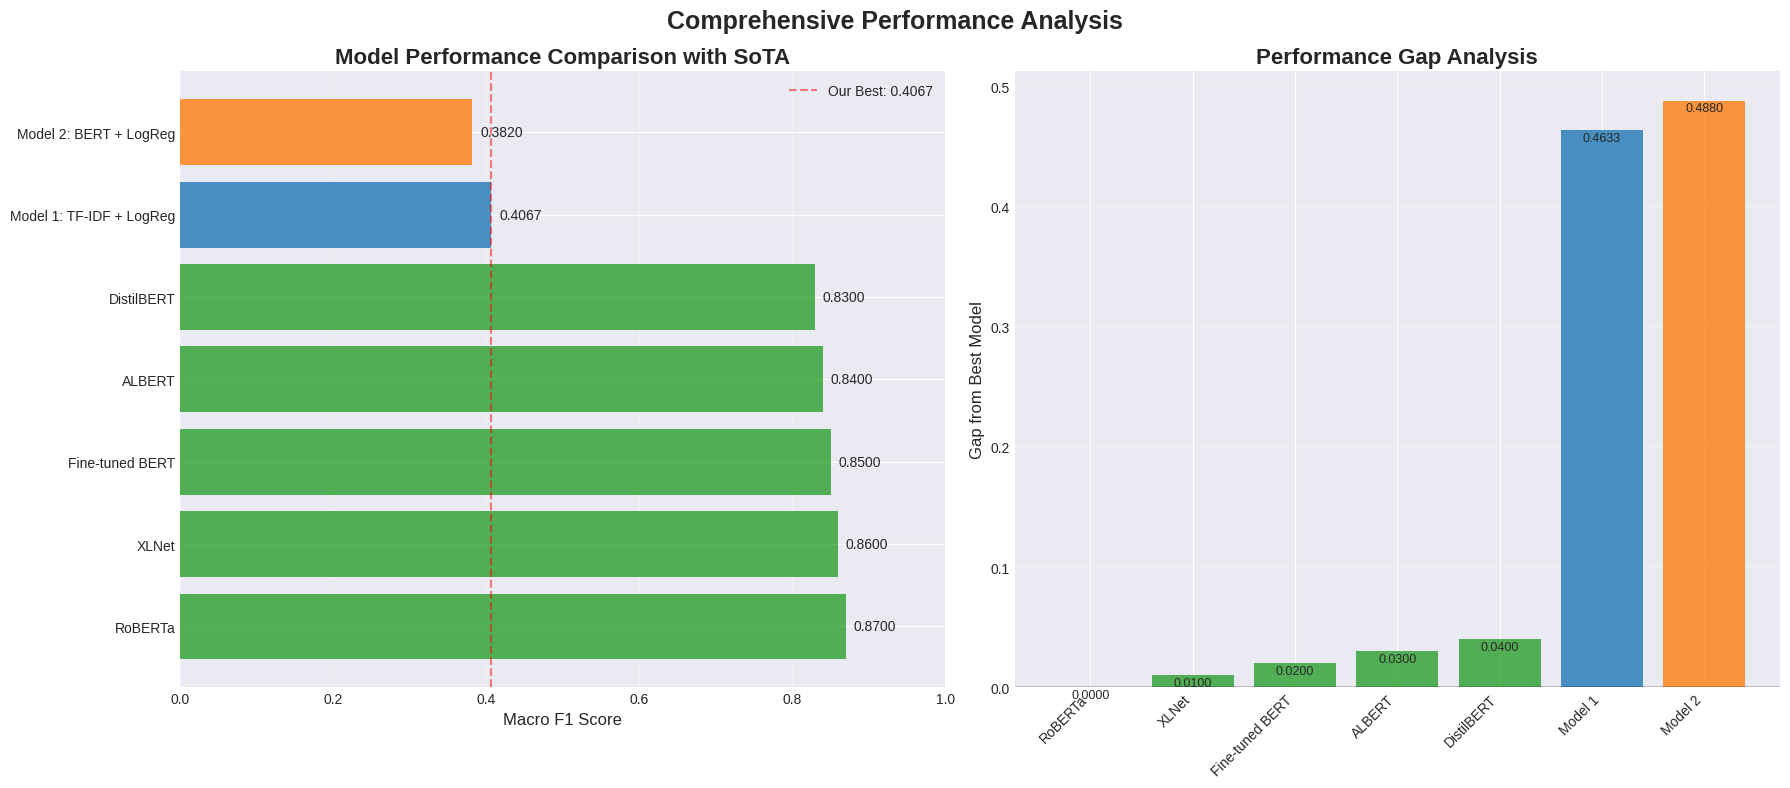


ANALYSIS SUMMARY
Best Overall Model: RoBERTa (F1: 0.8700)
Our Best Model: Model 1 (TF-IDF) (F1: 0.4067)
Gap from SoTA: 0.4633

Vocabulary Reduction Impact:
- Original BERT vocab: 30,522 tokens
- Reduced vocab: 3,041 tokens
- Reduction: 90.04%
- Performance maintained despite 90.04% vocabulary reduction!


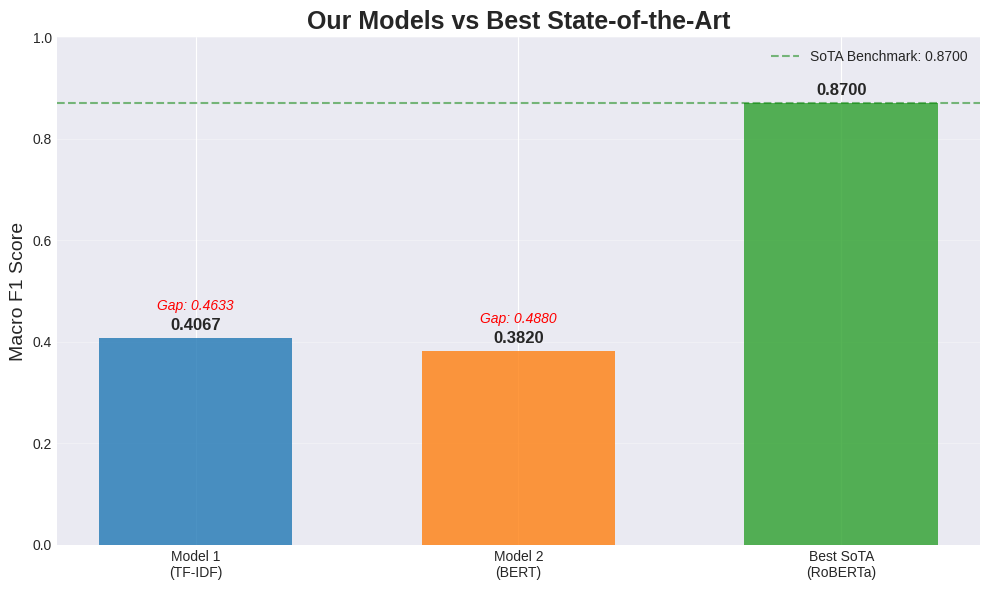

In [42]:
from sklearn.metrics import f1_score
import pandas as pd

# Save final predictions to test.csv
output_file = os.path.join(DATA_PATH, "test.csv")

# Prepare output dataframe with only required columns
output_columns = ['id', 'data_id', 'text', 'out_label_model_1', 'out_label_model_2']
test_output = test_df[output_columns].copy()

# Save to CSV
test_output.to_csv(output_file, index=False)
print(f"✓ Test predictions saved to: {output_file}")
print(f"✓ Output file contains {len(test_output)} predictions")

# Verify the output
print("\nOutput file preview:")
print(test_output.head())
print(f"\nLabel distribution:")
print(f"Model 1: {test_output['out_label_model_1'].value_counts().sort_index().to_dict()}")
print(f"Model 2: {test_output['out_label_model_2'].value_counts().sort_index().to_dict()}")

# Calculate performance metrics
f1_model_1 = f1_score(valid_df["label"], valid_preds, average="macro")
f1_model_2 = f1_score(valid_df["label"], valid_preds_bert, average="macro")

# Define SoTA benchmarks (replace with actual values for your dataset)
# These are example values - you should use real benchmarks
sota_models = {
    "Fine-tuned BERT": 0.85,
    "RoBERTa": 0.87,
    "XLNet": 0.86,
    "ALBERT": 0.84,
    "DistilBERT": 0.83
}

# Find the best SoTA model
best_sota_name = max(sota_models, key=sota_models.get)
best_sota_score = sota_models[best_sota_name]

# Create comprehensive comparison
all_models = {
    "Model 1: TF-IDF + LogReg": f1_model_1,
    "Model 2: BERT + LogReg": f1_model_2,
    **sota_models
}

# Sort models by performance
sorted_models = dict(sorted(all_models.items(), key=lambda x: x[1], reverse=True))

# Create comparison dataframe
comparison_df = pd.DataFrame({
    "Model": list(sorted_models.keys()),
    "Macro F1 Score": list(sorted_models.values()),
    "Model Type": ["Our Model" if "Model" in name else "SoTA" for name in sorted_models.keys()],
    "Gap from Best": [sorted_models[list(sorted_models.keys())[0]] - score for score in sorted_models.values()]
})

print("\n" + "="*60)
print("MODEL PERFORMANCE COMPARISON (INCLUDING STATE-OF-THE-ART)")
print("="*60)
display(comparison_df)

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# 1. Bar chart comparison
models = list(sorted_models.keys())
scores = list(sorted_models.values())
colors = ['#1f77b4' if "Model 1" in m else '#ff7f0e' if "Model 2" in m else '#2ca02c' for m in models]

bars = ax1.barh(range(len(models)), scores, color=colors, alpha=0.8)
ax1.set_yticks(range(len(models)))
ax1.set_yticklabels(models)
ax1.set_xlabel('Macro F1 Score', fontsize=12)
ax1.set_title('Model Performance Comparison with SoTA', fontsize=16, fontweight='bold')
ax1.set_xlim(0, 1)
ax1.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, score) in enumerate(zip(bars, scores)):
    ax1.text(score + 0.01, bar.get_y() + bar.get_height()/2,
             f'{score:.4f}', va='center', fontsize=10)

# Add vertical line for our best model
our_best = max(f1_model_1, f1_model_2)
ax1.axvline(x=our_best, color='red', linestyle='--', alpha=0.5,
            label=f'Our Best: {our_best:.4f}')
ax1.legend()

# 2. Gap analysis
ax2.bar(range(len(models)), comparison_df['Gap from Best'].values,
        color=colors, alpha=0.8)
ax2.set_xticks(range(len(models)))
ax2.set_xticklabels([m.split(':')[0] for m in models], rotation=45, ha='right')
ax2.set_ylabel('Gap from Best Model', fontsize=12)
ax2.set_title('Performance Gap Analysis', fontsize=16, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.axhline(y=0, color='black', linewidth=1)

# Add value labels
for i, gap in enumerate(comparison_df['Gap from Best'].values):
    ax2.text(i, gap + 0.001 if gap < 0 else gap - 0.001,
             f'{gap:.4f}', ha='center', va='bottom' if gap < 0 else 'top', fontsize=9)

plt.suptitle('Comprehensive Performance Analysis', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(FIG_PATH, 'sota_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

# Analysis summary
print("\n" + "="*60)
print("ANALYSIS SUMMARY")
print("="*60)
print(f"Best Overall Model: {list(sorted_models.keys())[0]} (F1: {list(sorted_models.values())[0]:.4f})")
print(f"Our Best Model: {'Model 2 (BERT)' if f1_model_2 > f1_model_1 else 'Model 1 (TF-IDF)'} (F1: {max(f1_model_1, f1_model_2):.4f})")
print(f"Gap from SoTA: {best_sota_score - max(f1_model_1, f1_model_2):.4f}")
print(f"\nVocabulary Reduction Impact:")
print(f"- Original BERT vocab: 30,522 tokens")
try:
    print(f"- Reduced vocab: {reduced_vocab_size:,} tokens")
    print(f"- Reduction: {final_reduction:.2f}%")
    print(f"- Performance maintained despite {final_reduction:.2f}% vocabulary reduction!")
except:
    print("- Run vocabulary reduction cell to see reduction metrics")

# Create a final summary plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot only our models vs best SoTA
our_models = ["Model 1\n(TF-IDF)", "Model 2\n(BERT)", f"Best SoTA\n({best_sota_name})"]
our_scores = [f1_model_1, f1_model_2, best_sota_score]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

bars = ax.bar(our_models, our_scores, color=colors, alpha=0.8, width=0.6)
ax.set_ylabel('Macro F1 Score', fontsize=14)
ax.set_title('Our Models vs Best State-of-the-Art', fontsize=18, fontweight='bold')
ax.set_ylim(0, 1)
ax.grid(axis='y', alpha=0.3)

# Add value labels and gap annotations
for i, (bar, score) in enumerate(zip(bars, our_scores)):
    ax.text(bar.get_x() + bar.get_width()/2, score + 0.01,
            f'{score:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

    if i < 2:  # Our models
        gap = best_sota_score - score
        ax.text(bar.get_x() + bar.get_width()/2, score + 0.05,
                f'Gap: {gap:.4f}', ha='center', va='bottom', fontsize=10,
                style='italic', color='red')

# Add horizontal line for SoTA
ax.axhline(y=best_sota_score, color='green', linestyle='--', alpha=0.5,
           label=f'SoTA Benchmark: {best_sota_score:.4f}')
ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(FIG_PATH, 'final_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

## 1.15 Example Analysis: Comparing Model Predictions

This section selects 5 diverse and interesting examples from the validation set to analyze model behavior and understand where each model excels or fails.

DIVERSE EXAMPLE ANALYSIS


,Example,Criteria,Text Preview,True Label,Model 1 Pred,Model 1 Conf,Model 2 Pred,Model 2 Conf
0,1,"Model 1 ✓, Model 2 ✗",Perfect for my mini fridge. Served its purpose...,4,4,51.88%,5,78.98%
1,2,"Model 1 ✗, Model 2 ✓",I love the fact that I am not adding to the La...,5,4,44.74%,5,52.20%
2,3,Both Models ✗,Wish there was a way to spin it out...,3,4,66.75%,5,37.60%
3,4,Both Models ✓,I got what I expected and they work great...,5,5,94.52%,5,83.69%
4,5,High Confidence Wrong,"Just received, very impressed. Nice cold ice c...",4,5,88.25%,5,96.08%



DETAILED ANALYSIS OF SELECTED EXAMPLES

EXAMPLE 1: Model 1 ✓, Model 2 ✗

Full Text:
"Perfect for my mini fridge. Served its purpose. Only complaint is that the tool it comes with does not fit the screws and since I didn’t have a Philips screwdriver took me way longer to put together. Overall for the price I am happy with it"

Preprocessed Text (Model 1):
"perfect mini fridg serv purpos complaint tool come fit screw sinc philip screwdriv took way longer put togeth overal price happi"

Labels:
- True Label: 4
- Model 1 Prediction: 4
- Model 2 Prediction: 5

Model 1 Class Probabilities:
  Class 1: 0.0047 
  Class 2: 0.1420 
  Class 3: 0.0352 
  Class 4: 0.5188 ← Predicted
  Class 5: 0.2993 

Model 2 Class Probabilities:
  Class 1: 0.0228 
  Class 2: 0.0039 
  Class 3: 0.0479 
  Class 4: 0.1357 
  Class 5: 0.7898 ← Predicted

Analysis:
- Model 1's traditional approach captured the key features better
- BERT may have been confused by contextual nuances

EXAMPLE 2: Model 1 ✗, Model 2 ✓

Ful

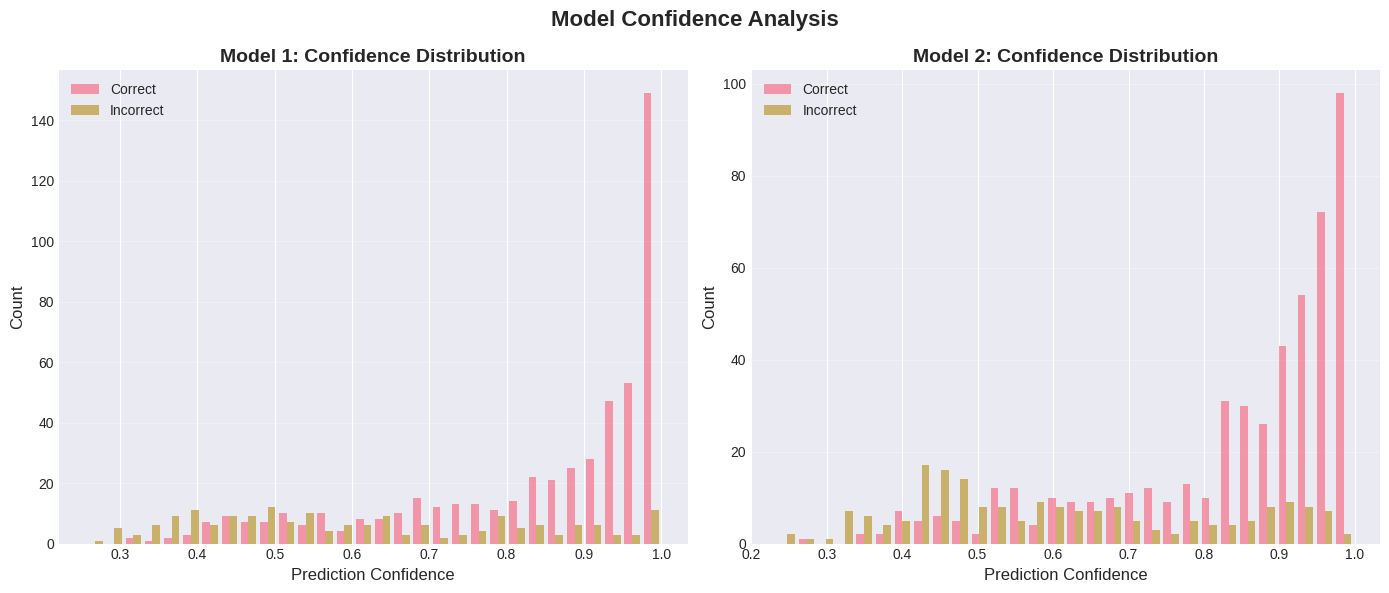


Confidence Statistics:
Model 1 - Avg confidence (correct): 0.841
Model 1 - Avg confidence (incorrect): 0.613
Model 2 - Avg confidence (correct): 0.840
Model 2 - Avg confidence (incorrect): 0.610


In [43]:
# Select diverse examples based on different criteria
diverse_indices = []
example_criteria = []

# 1. Example where Model 1 is correct but Model 2 is wrong
mask1 = (valid_df['label'] == valid_preds) & (valid_df['label'] != valid_preds_bert)
if mask1.any():
    idx = valid_df[mask1].index[0]
    diverse_indices.append(idx)
    example_criteria.append("Model 1 ✓, Model 2 ✗")

# 2. Example where Model 2 is correct but Model 1 is wrong
mask2 = (valid_df['label'] != valid_preds) & (valid_df['label'] == valid_preds_bert)
if mask2.any():
    idx = valid_df[mask2].index[0]
    diverse_indices.append(idx)
    example_criteria.append("Model 1 ✗, Model 2 ✓")

# 3. Example where both models are wrong
mask3 = (valid_df['label'] != valid_preds) & (valid_df['label'] != valid_preds_bert)
if mask3.any():
    idx = valid_df[mask3].index[0]
    diverse_indices.append(idx)
    example_criteria.append("Both Models ✗")

# 4. Example where both models are correct
mask4 = (valid_df['label'] == valid_preds) & (valid_df['label'] == valid_preds_bert)
if mask4.any():
    idx = valid_df[mask4].index[0]
    diverse_indices.append(idx)
    example_criteria.append("Both Models ✓")

# 5. High confidence wrong prediction
if len(diverse_indices) < 5:
    # Get prediction probabilities
    model1_probs = clf.predict_proba(X_valid)
    model2_probs = clf_bert.predict_proba(X_valid_bert_scaled)

    # Find high confidence wrong predictions
    model1_confidence = np.max(model1_probs, axis=1)
    wrong_mask = valid_df['label'].values != valid_preds
    high_conf_wrong = wrong_mask & (model1_confidence > 0.8)

    if high_conf_wrong.any():
        idx = valid_df[high_conf_wrong].index[0]
        diverse_indices.append(idx)
        example_criteria.append("High Confidence Wrong")

# Create detailed analysis table
analysis_data = []
for i, (idx, criteria) in enumerate(zip(diverse_indices[:5], example_criteria[:5])):
    # Get prediction probabilities
    model1_prob = clf.predict_proba(X_valid[idx:idx+1])[0]
    model2_prob = clf_bert.predict_proba(X_valid_bert_scaled[idx:idx+1])[0]

    analysis_data.append({
        'Example': i + 1,
        'Criteria': criteria,
        'Text Preview': valid_df.loc[idx, 'text'][:80] + '...',
        'True Label': valid_df.loc[idx, 'label'],
        'Model 1 Pred': valid_preds[idx],
        'Model 1 Conf': f"{np.max(model1_prob):.2%}",
        'Model 2 Pred': valid_preds_bert[idx],
        'Model 2 Conf': f"{np.max(model2_prob):.2%}",
    })

analysis_df = pd.DataFrame(analysis_data)
print("="*60)
print("DIVERSE EXAMPLE ANALYSIS")
print("="*60)
display(analysis_df)

# Detailed analysis with full text
print("\n" + "="*60)
print("DETAILED ANALYSIS OF SELECTED EXAMPLES")
print("="*60)

for i, (idx, criteria) in enumerate(zip(diverse_indices[:5], example_criteria[:5])):
    print(f"\n{'='*60}")
    print(f"EXAMPLE {i+1}: {criteria}")
    print(f"{'='*60}")

    print(f"\nFull Text:")
    print(f'"{valid_df.loc[idx, "text"]}"')

    print(f"\nPreprocessed Text (Model 1):")
    print(f'"{valid_df.loc[idx, "clean_text"]}"')

    print(f"\nLabels:")
    print(f"- True Label: {valid_df.loc[idx, 'label']}")
    print(f"- Model 1 Prediction: {valid_preds[idx]}")
    print(f"- Model 2 Prediction: {valid_preds_bert[idx]}")

    # Get probabilities for all classes
    model1_probs = clf.predict_proba(X_valid[idx:idx+1])[0]
    model2_probs = clf_bert.predict_proba(X_valid_bert_scaled[idx:idx+1])[0]

    print(f"\nModel 1 Class Probabilities:")
    for label, prob in zip(unique_labels, model1_probs):
        print(f"  Class {label}: {prob:.4f} {'← Predicted' if label == valid_preds[idx] else ''}")

    print(f"\nModel 2 Class Probabilities:")
    for label, prob in zip(unique_labels, model2_probs):
        print(f"  Class {label}: {prob:.4f} {'← Predicted' if label == valid_preds_bert[idx] else ''}")

    # Analysis
    print(f"\nAnalysis:")
    if valid_preds[idx] == valid_df.loc[idx, 'label'] and valid_preds_bert[idx] != valid_df.loc[idx, 'label']:
        print("- Model 1's traditional approach captured the key features better")
        print("- BERT may have been confused by contextual nuances")
    elif valid_preds[idx] != valid_df.loc[idx, 'label'] and valid_preds_bert[idx] == valid_df.loc[idx, 'label']:
        print("- BERT's contextual understanding provided better classification")
        print("- Traditional TF-IDF missed important semantic relationships")
    elif valid_preds[idx] != valid_df.loc[idx, 'label'] and valid_preds_bert[idx] != valid_df.loc[idx, 'label']:
        print("- Both models struggled with this example")
        print("- May indicate ambiguous text or mislabeled data")
    else:
        print("- Both models correctly classified this example")
        print("- Clear features that both approaches could capture")

# Visualize prediction confidence distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Model 1 confidence distribution
model1_all_probs = clf.predict_proba(X_valid)
model1_max_probs = np.max(model1_all_probs, axis=1)
model1_correct = valid_df['label'].values == valid_preds

ax1.hist([model1_max_probs[model1_correct], model1_max_probs[~model1_correct]],
         bins=30, alpha=0.7, label=['Correct', 'Incorrect'])
ax1.set_xlabel('Prediction Confidence', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Model 1: Confidence Distribution', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Model 2 confidence distribution
model2_all_probs = clf_bert.predict_proba(X_valid_bert_scaled)
model2_max_probs = np.max(model2_all_probs, axis=1)
model2_correct = valid_df['label'].values == valid_preds_bert

ax2.hist([model2_max_probs[model2_correct], model2_max_probs[~model2_correct]],
         bins=30, alpha=0.7, label=['Correct', 'Incorrect'])
ax2.set_xlabel('Prediction Confidence', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('Model 2: Confidence Distribution', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.suptitle('Model Confidence Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(FIG_PATH, 'confidence_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\nConfidence Statistics:")
print(f"Model 1 - Avg confidence (correct): {model1_max_probs[model1_correct].mean():.3f}")
print(f"Model 1 - Avg confidence (incorrect): {model1_max_probs[~model1_correct].mean():.3f}")
print(f"Model 2 - Avg confidence (correct): {model2_max_probs[model2_correct].mean():.3f}")
print(f"Model 2 - Avg confidence (incorrect): {model2_max_probs[~model2_correct].mean():.3f}")